In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

# Imports

In [1]:
!pip install nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!pip -q install ktrain requests

In [3]:
#!python -m spacy download pt_core_news_sm

In [4]:
import pandas as pd
import numpy as np
import json
import pickle as pkl

import yaml

# import ktrain 
# from ktrain import text as txt

import uuid

import re
# import spacy
# from spacy.lang.pt.examples import sentences 
# from spacy.training import offsets_to_biluo_tags

# Carregando dados

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Dataframe que servirá para o treinamento iterativo dos modelos
# df_test = pd.read_csv('/content/tccF/df_test.csv')
# df_test = pd.read_csv('/content/df_test.csv')
df_test = pd.read_csv('/content/drive/MyDrive/tccF/df_test.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test

id    id_ato                                              texto  \
0    444   631-R47  EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1     51   634-R93  EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    140  628-R103  EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    242   630-R76  EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    624   671-R49  EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..   ...       ...                                                ...   
375  273  637-R130  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  594  626-R141  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  704  639-R143  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  436   631-R35  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  637    640-R1  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                                 label  
0    {'partes_contratuais': ['INSTITUTO DE ASSIST. ...  
1    {'numero_contrato': ['45384/2021', '45384/2021...  
2    {'partes_contratuais': ['DF/SECEC/FAC', 'WAYNE...  
3    {'natureza_despesa': ['339039'], 'numero_contr...  
4    {'partes_contratuais': ['Companhia de Planejam...  
..                                                 ...  
375  {'partes_contratuais': ['SECRETARIA DE ESTADO ...  
376  {'natureza_despesa': ['449052'], 'partes_contr...  
377  {'partes_contratuais': ['INSTITUTO DE ASSIST. ...  
378  {'partes_contratuais': ['INSTITUTO DE ASSIST. ...  
379  {'numero_contrato': ['26/2022'], 'processo_gdf...  

[380 rows x 4 columns]

In [7]:
print(len(df_test))

380


In [8]:
# definindo as samples (textos dos atos) em que serão aplicados os modelo
test_data = [ [df_test['id'][j],df_test['texto'][j],df_test['label'][j]]  for j in range(len(list(df_test['id']))) ]
samples = [test_data[i][1] for i in range(len(test_data))]
print(len(samples))

380


# Definindo Df_csv:

In [9]:
table_1 = pd.DataFrame()
table_2 = pd.DataFrame()
table_3 = pd.DataFrame()
fig_2 = pd.DataFrame()
fig_3 = pd.DataFrame()
fig_3_1 = pd.DataFrame()


# aux =[]
# aux.append(metrics)
# table_1['GPT-3'] = y + aux

# HUMANO Finding best entities

## pegando pickle

In [13]:
import pickle as pkl

with open("/content/drive/MyDrive/SavesFinal/t2/dict_ner_news.pkl", "rb") as f:
    dict_ner_news = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t2/dict_bertlenerbr.pkl", "rb") as f:
    dict_bertlenerbr = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t2/dict_distilbert.pkl", "rb") as f:
    dict_distilbert = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t2/dict_portuguese.pkl", "rb") as f:
    dict_portuguese = pkl.load(f)

with open("/content/drive/MyDrive/SavesFinal/t2/dict_roberta.pkl", "rb") as f:
    dict_roberta = pkl.load(f)
 

## Avaliando outputs dos modelos com dados de teste:

### Avaliando

In [14]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [15]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [16]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [17]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [18]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE ASSIST . À SAÚDE DOS SERV . DO DF INAS', 'partes_contratuais'), ('COOP', 'parte

In [19]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [20]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (204/2021, numer...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (140/2021, nu...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [21]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [22]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [23]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 3590,
    'incorrect': 74,
    'partial': 0,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.8224513172966781,
    'recall': 0.8235833906859371,
    'f1': 0.823016964695094},
   'partial': {'correct': 2928,
    'incorrect': 0,
    'partial': 736,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.7550973654066437,
    'recall': 0.7561367286074788,
    'f1': 0.7556166895919303},
   'strict': {'correct': 2896,
    'incorrect': 768,
    'partial': 0,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.663459335624284,
    'recall': 0.6643725625143382,
    'f1': 0.6639156350298028},
   'exact': {'correct': 2928,
    'incorrect': 736,
    'partial': 0,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.6707903780068728,
    'recall': 0.6717136958017894,

### Teste 1:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.7556166895919303, 0.7611569314201787, 0.7071053477655128, 0.631984585741811, 0.5515314106863403]


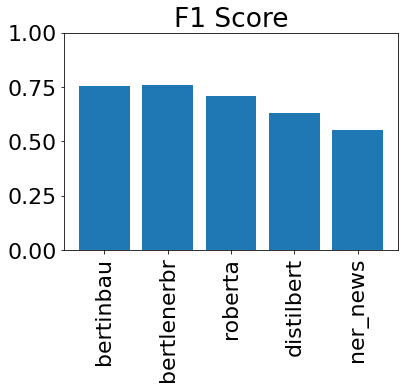

In [24]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

### test 2


['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9630512514898689, 0.9588859416445623, 0.6722428748451053, 0.48754789272030646, 0.876632801161103, 0.5413385826771653, 0.5160462130937099, 0.7924187725631769, 0.9126637554585154, 0.8996478873239436, 0.8851744186046512, 0.9587264150943396, 0.9680851063829786, 0.6509988249118683, 0.5650406504065041, 0.8850267379679144, 0.5613682092555332, 0.4663278271918678, 0.7911504424778761, 0.9127324749642346, 0.9092495636998255, 0.8879310344827586, 0.9168564920273349, 0.9627163781624501, 0.4691762138570649, 0.45641447368421056, 0.8890374331550802, 0.6263157894736843, 0.5024630541871922, 0.7943262411347518, 0.9107913669064749, 0.9066901408450704, 0.9037356321839081, 0.8540540540540541, 0.8478581979320532, 0.5310633213859021, 0

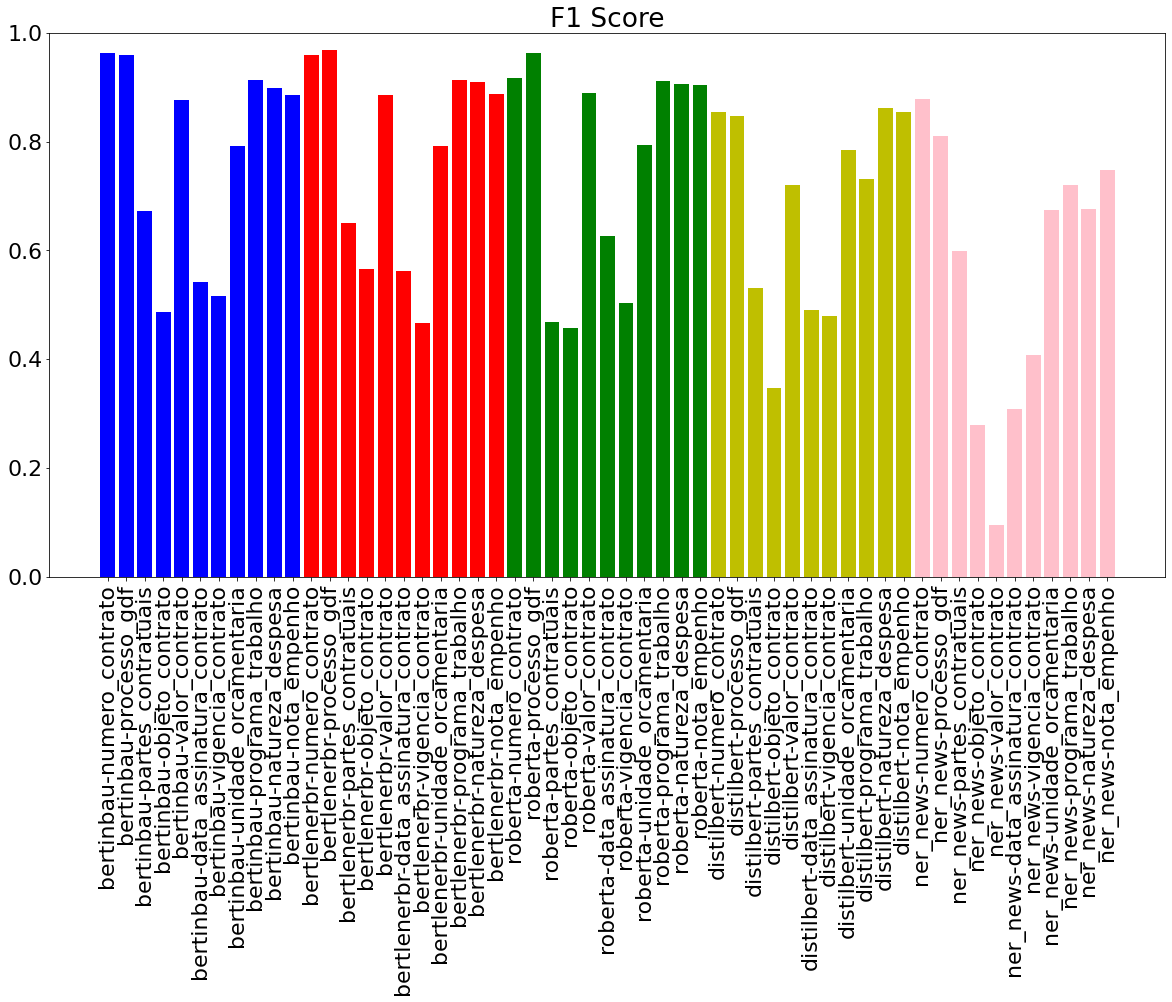

In [25]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9630512514898689, 0.9588859416445623, 0.6722428748451053, 0.48754789272030646, 0.876632801161103, 0.5413385826771653, 0.5160462130937099, 0.7924187725631769, 0.9126637554585154, 0.8996478873239436, 0.8851744186046512, 0.9587264150943396, 0.9680851063829786, 0.6509988249118683, 0.5650406504065041, 0.8850267379679144, 0.5613682092555332, 0.4663278271918678, 0.7911504424778761, 0.9127324749642346, 0.9092495636998255, 0.8879310344827586, 0.9168564920273349, 0.9627163781624501, 0.4691762138570649, 0.45641447368421056, 0.8890374331550802, 0.6263157894736843, 0.5024630541871922, 0.7943262411347518, 0.9107913669064749, 0.9066901408450704, 0.9037356321839081, 0.8540540540540541, 0.8478581979320532, 0.5310633213859021, 0

Text(0.5, 1.0, 'F1 Score')

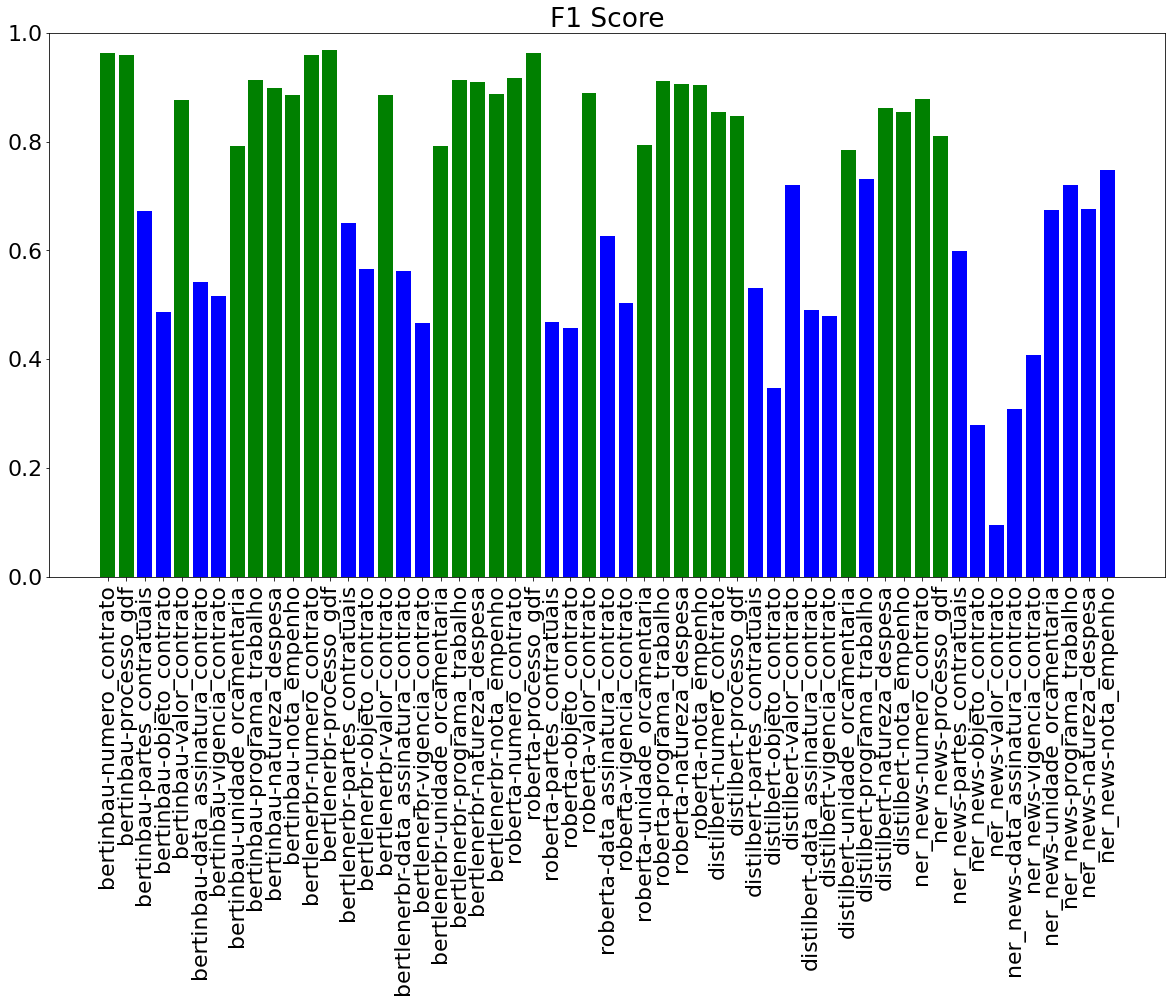

In [26]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*55

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


### teste 3:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9630512514898689, 0.9588859416445623, 0.6722428748451053, 0.48754789272030646, 0.876632801161103, 0.5413385826771653, 0.5160462130937099, 0.7924187725631769, 0.9126637554585154, 0.8996478873239436, 0.8851744186046512, 0.9587264150943396, 0.9680851063829786, 0.6509988249118683, 0.5650406504065041, 0.8850267379679144, 0.5613682092555332, 0.4663278271918678, 0.7911504424778761, 0.9127324749642346, 0.9092495636998255, 0.8879310344827586, 0.9168564920273349, 0.9627163781624501, 0.4691762138570649, 0.45641447368421056, 0.8890374331550802, 0.6263157894736843, 0.5024630541871922, 0.7943262411347518, 0.9107913669064749, 0.9066901408450704, 0.9037356321839081, 0.8540540540540541, 0.8478581979320532, 0.5310633213859021, 0

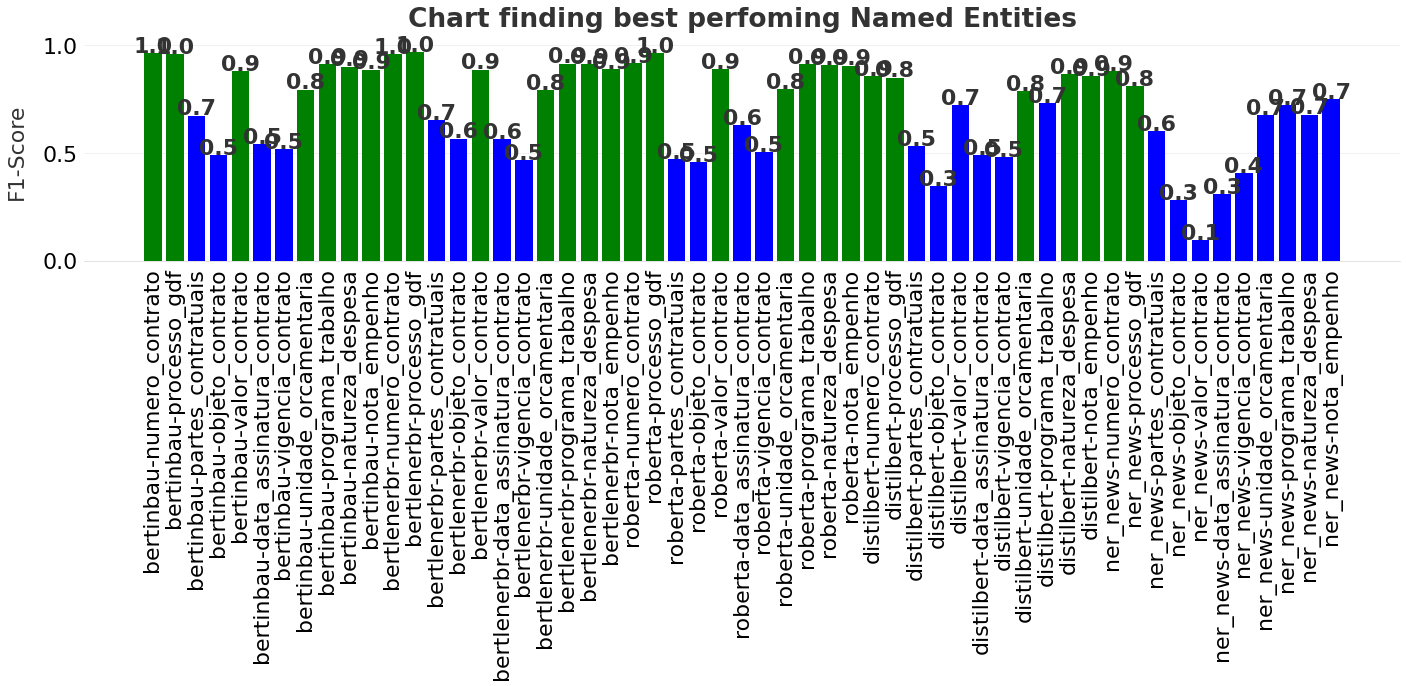

In [27]:
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*55

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))

# Save the chart so we can loop through the bars below.
bars = ax.bar(x, y, color = colors)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height()+0.005,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='#333333',
      weight='bold'
  )

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel('F1-Score', labelpad=15, color='#333333')
ax.set_title('Chart finding best perfoming Named Entities', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()

In [28]:
# labels = [
#     'BERTimbau-contract-number','BERTimbau-GDF-process','BERTimbau-contractual-parties','BERTimbau-','BERTimbau-','BERTimbau-','BERTimbau-','BERTimbau-','BERTimbau-','BERTimbau-','BERTimbau-',
#     'LenerBR-contract-number','LenerBR-GDF-process','LenerBR-contractual-parties','LenerBR-','LenerBR-','LenerBR-','LenerBR-','LenerBR-','LenerBR-','LenerBR-','LenerBR-',
#     'RoBERTa-contract-number','RoBERTa-GDF-process','RoBERTa-contractual-parties','RoBERTa-','RoBERTa-','RoBERTa-','RoBERTa-','RoBERTa-','RoBERTa-','RoBERTa-','RoBERTa-',
#     'DistilBERT-PT-contract-number','DistilBERT-PT-GDF-process','DistilBERT-PT-contractual-parties','DistilBERT-PT-','DistilBERT-PT-','DistilBERT-PT-','DistilBERT-PT-','DistilBERT-PT-','DistilBERT-PT-','DistilBERT-PT-','DistilBERT-PT-',
# ]
models_name = [
    'BERTimbau',
    'LenerBR',
    'RoBERTa',
    'DistilBERT-PT',
    'NER-News',
]

entities =[
    'contract-number',
    'GDF-process',
    'contractual-parties',
    'contract-object',
    'contract-date',
    'contract-value',
    'contract-duration',
    'budget-unit',
    'work-program',
    'nature-of-expenditure',
    'commitment-note',
          ]

#labels = [i+'-'+j for i in models_name for j in entities]
labels = [j for i in models_name for j in entities]
labels

['contract-number',
 'GDF-process',
 'contractual-parties',
 'contract-object',
 'contract-date',
 'contract-value',
 'contract-duration',
 'budget-unit',
 'work-program',
 'nature-of-expenditure',
 'commitment-note',
 'contract-number',
 'GDF-process',
 'contractual-parties',
 'contract-object',
 'contract-date',
 'contract-value',
 'contract-duration',
 'budget-unit',
 'work-program',
 'nature-of-expenditure',
 'commitment-note',
 'contract-number',
 'GDF-process',
 'contractual-parties',
 'contract-object',
 'contract-date',
 'contract-value',
 'contract-duration',
 'budget-unit',
 'work-program',
 'nature-of-expenditure',
 'commitment-note',
 'contract-number',
 'GDF-process',
 'contractual-parties',
 'contract-object',
 'contract-date',
 'contract-value',
 'contract-duration',
 'budget-unit',
 'work-program',
 'nature-of-expenditure',
 'commitment-note',
 'contract-number',
 'GDF-process',
 'contractual-parties',
 'contract-object',
 'contract-date',
 'contract-value',
 'contract-

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.9630512514898689, 0.9588859416445623, 0.6722428748451053, 0.48754789272030646, 0.876632801161103, 0.5413385826771653, 0.5160462130937099, 0.7924187725631769, 0.9126637554585154, 0.8996478873239436, 0.8851744186046512, 0.9587264150943396, 0.9680851063829786, 0.6509988249118683, 0.5650406504065041, 0.8850267379679144, 0.5613682092555332, 0.4663278271918678, 0.7911504424778761, 0.9127324749642346, 0.9092495636998255, 0.8879310344827586, 0.9168564920273349, 0.9627163781624501, 0.4691762138570649, 0.45641447368421056, 0.8890374331550802, 0.6263157894736843, 0.5024630541871922, 0.7943262411347518, 0.9107913669064749, 0.9066901408450704, 0.9037356321839081, 0.8540540540540541, 0.8478581979320532, 0.5310633213859021, 0.3465679676985195, 0.7199367088607594, 0.489795918367347, 0.4785801713586292, 0.7853211009174312, 0.7307060755336617, 0.862708719851577, 0.8536953242835594, 0.8785811732605731,

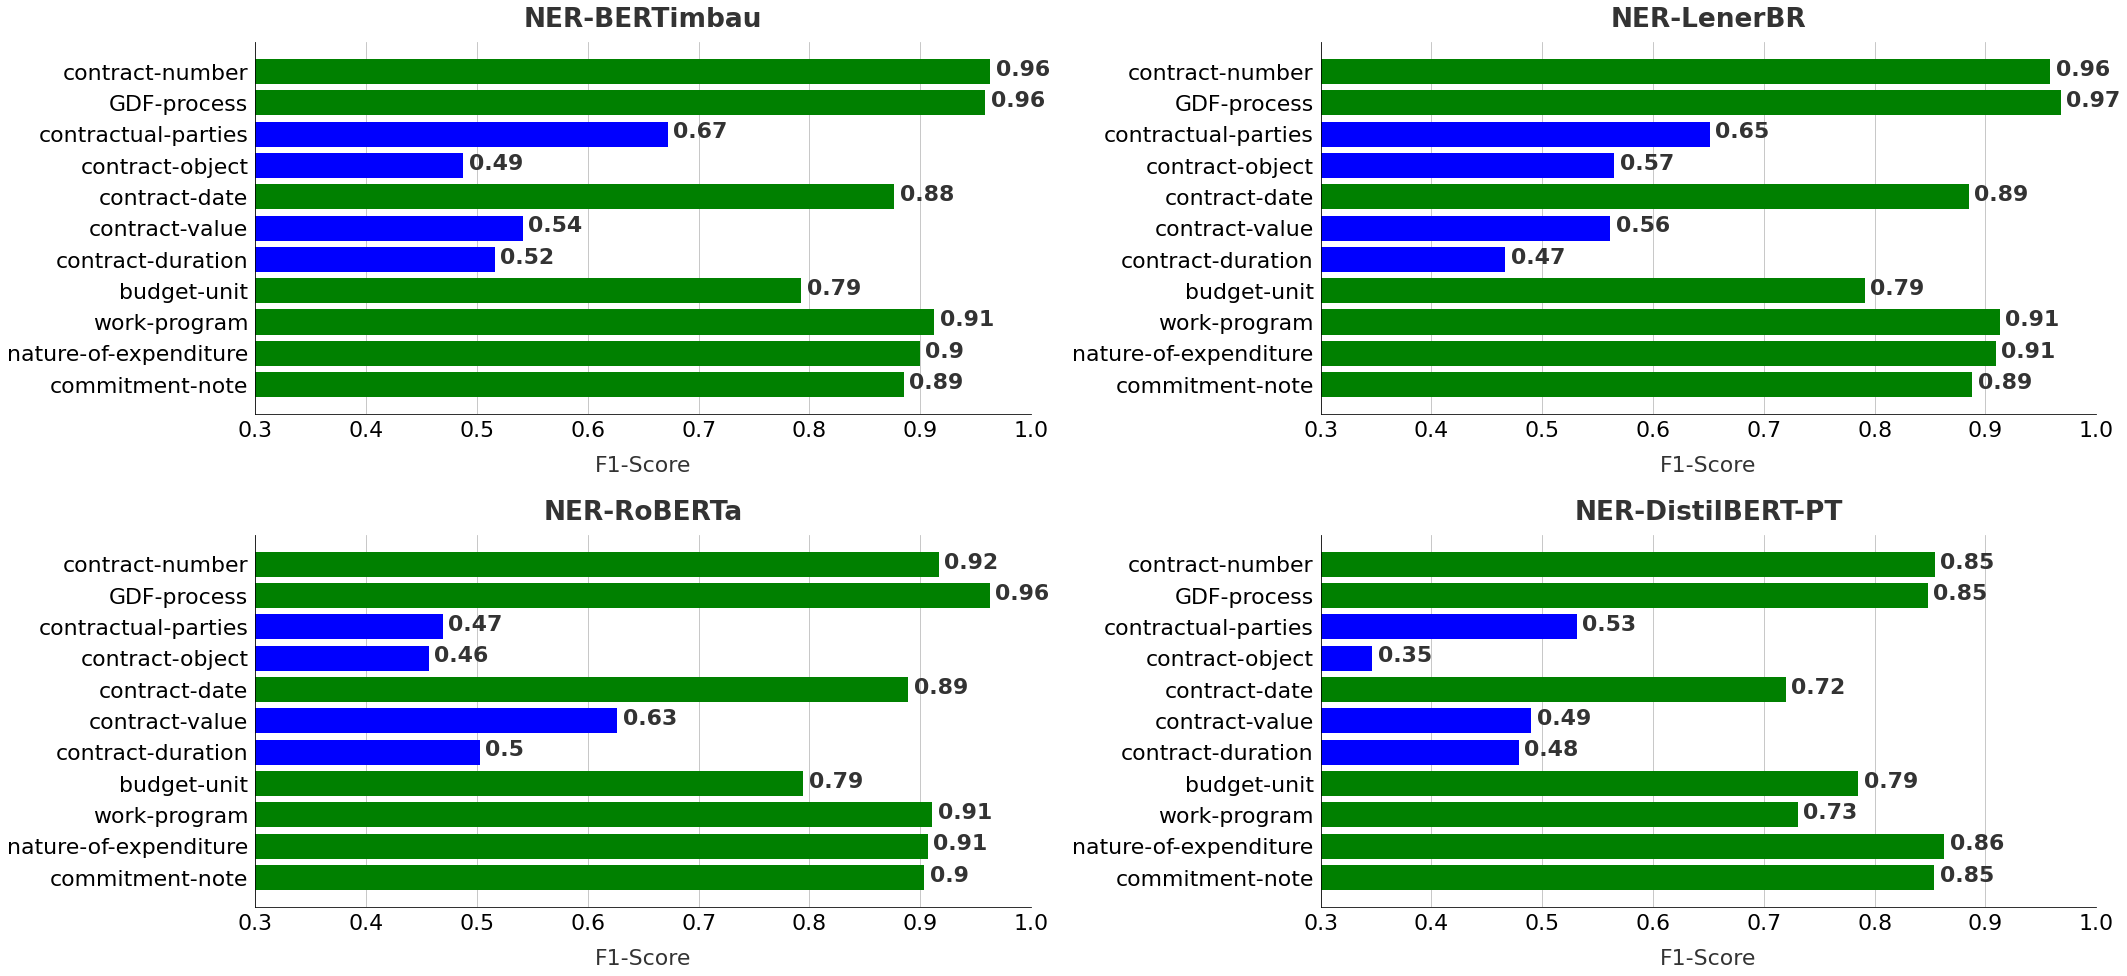

In [29]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

#labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['g','g','g','g','b','b','g','b','b','g','g']

# fig, ax = plt.subplots(2, 3,figsize=(30, 10))
# ax[1][2].set_visible(False)

fig = plt.figure(figsize=(40, 30))

print(y[0:11])
#yi =  [y[0:11],y[11:22],y[22:33],y[33:44],y[44:55],[]]
y = y[::-1]
yi =  [y[44:55],y[33:44],y[22:33],y[11:22]]
labels = labels[::-1]
labelsi =  [labels[44:55],labels[33:44],labels[22:33],labels[11:22]]

ax1 = plt.subplot2grid((3,4), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)

ax_vet=[ax1,ax2,ax3,ax4]

# Save the chart so we can loop through the bars below.
cont=0
for i in ax_vet:
    bars = i.barh(x, yi[cont], color = colors)

    # Axis formatting.
    i.spines['top'].set_visible(False)
    i.spines['right'].set_visible(False)
    #i.spines['left'].set_visible(False)
    #i.spines['bottom'].set_color('#DDDDDD')
    i.tick_params(bottom=False, left=False)
    i.set_axisbelow(True)
    #i.yaxis.grid(True, color='#EEEEEE')
    i.xaxis.grid(True, color='#BBBBBB')

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      i.text(
          bar.get_width()+0.005,
          bar.get_y() + bar.get_height()/3,
          round(bar.get_width(), 2),
          #horizontalalignment='center',
          color='#333333',
          weight='bold'
      )

    # # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # # extra space between the text and the tick labels.
    i.set_yticks(x)
    i.set_yticklabels(labelsi[cont])
    i.set_xlabel('F1-Score', labelpad=15, color='#333333')
    i.set_xlim([0.3, 1])
    # i.set_title('Chart finding best perfoming Named Entities', pad=15, color='#333333',
    #             weight='bold')
    cont+=1 

ax1.set_title('NER-BERTimbau', pad=15, color='#333333',weight='bold')
ax2.set_title('NER-LenerBR', pad=15, color='#333333',weight='bold')
ax3.set_title('NER-RoBERTa', pad=15, color='#333333',weight='bold')
ax4.set_title('NER-DistilBERT-PT', pad=15, color='#333333',weight='bold')

# ax2.plot([0.5, 0.5], [0, 1], color='#333333', lw=5,
#          transform=plt.gcf().transFigure, clip_on=False)
# ax2.plot([0, 1], [0.5, 0.5], color='#333333', lw=2,
#          transform=plt.gcf().transFigure, clip_on=False)

fig.tight_layout()
plt.savefig('chart1.pdf',pad_inches=0) 
plt.show()

### Coiso

In [30]:
fig_2['Entidades'] = entidadesExtratoContrato

aux_labels = ['Bertimbau','Bertlener','Roberta','Distlbert','NerNews']

for i in range(4):
  aux = yi[i]
  aux =  aux[::-1]
  fig_2[aux_labels[i]] = aux

In [31]:
fig_2

Entidades  Bertimbau  Bertlener   Roberta  Distlbert
0            numero_contrato   0.963051   0.958726  0.916856   0.854054
1               processo_gdf   0.958886   0.968085  0.962716   0.847858
2         partes_contratuais   0.672243   0.650999  0.469176   0.531063
3            objeto_contrato   0.487548   0.565041  0.456414   0.346568
4             valor_contrato   0.876633   0.885027  0.889037   0.719937
5   data_assinatura_contrato   0.541339   0.561368  0.626316   0.489796
6          vigencia_contrato   0.516046   0.466328  0.502463   0.478580
7       unidade_orcamentaria   0.792419   0.791150  0.794326   0.785321
8          programa_trabalho   0.912664   0.912732  0.910791   0.730706
9           natureza_despesa   0.899648   0.909250  0.906690   0.862709
10              nota_empenho   0.885174   0.887931  0.903736   0.853695

#GPT-3

## SALVANDO PICKLE

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/SavesFinal/t1/dict_ner_news.pkl", "rb") as f:
    dict_ner_news = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t1/dict_bertlenerbr.pkl", "rb") as f:
    dict_bertlenerbr = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t1/dict_distilbert.pkl", "rb") as f:
    dict_distilbert = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t1/dict_portuguese.pkl", "rb") as f:
    dict_portuguese = pkl.load(f)

with open("/content/drive/MyDrive/SavesFinal/t1/dict_roberta.pkl", "rb") as f:
    dict_roberta = pkl.load(f)
 

## Avaliando outputs dos modelos com dados de teste TODAS ENTIDADES:

### Avaliando

In [ ]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]


def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE', 'partes_contratuais'), ('COOP . BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'par

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (CODEPLAN, partes...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (00121.00000.0137...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(-, partes_contratuais), (00121.00000.0137/20...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (00367-0000040...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, processo_gdf), (00302-00001101/2021...   
4    [(00121.00000.0137/2021-58, processo_gdf), (CO...   
..                                                 ...   
375  [(045005/2021, processo_gdf), (00431-00020054/...   
376  [(45/2021, numero_contrato), (VISUAL INDUSTRIA...   
377  [(43.980/2021, numero_contrato), (040

In [ ]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 201,...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'processo_gdf', 'start': 47, 'end':...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'processo_gdf', 'start': 23, 'end':...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 2872,
    'incorrect': 179,
    'partial': 0,
    'missed': 1301,
    'spurious': 2059,
    'possible': 4352,
    'actual': 5110,
    'precision': 0.5620352250489237,
    'recall': 0.6599264705882353,
    'f1': 0.6070598182202495},
   'partial': {'correct': 2093,
    'incorrect': 0,
    'partial': 958,
    'missed': 1301,
    'spurious': 2059,
    'possible': 4352,
    'actual': 5110,
    'precision': 0.5033268101761252,
    'recall': 0.5909926470588235,
    'f1': 0.5436482773198056},
   'strict': {'correct': 2032,
    'incorrect': 1019,
    'partial': 0,
    'missed': 1301,
    'spurious': 2059,
    'possible': 4352,
    'actual': 5110,
    'precision': 0.39765166340508806,
    'recall': 0.46691176470588236,
    'f1': 0.4295075036990066},
   'exact': {'correct': 2093,
    'incorrect': 958,
    'partial': 0,
    'missed': 1301,
    'spurious': 2059,
    'possible': 4352,
    'actual': 5110,
    'precision': 0.4095890410958904,
    'recall': 0.480

### Teste 1:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.5436482773198056, 0.5547803335877031, 0.5427341668374667, 0.47321954090641555, 0.2786181740156635]


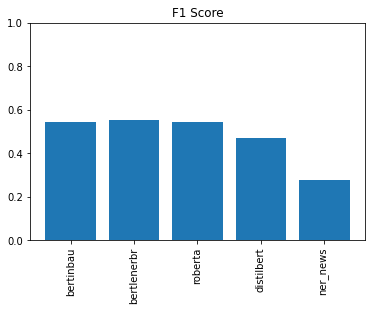

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_1['GPT-3'] = y 

### test 2


['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9018324607329844, 0.9543624161073826, 0.5081539465101109, 0.2853894258101194, 0.7912772585669783, 0.3677884615384615, 0.1811646297627606, 0.5789473684210525, 0.7245696400625977, 0.7217573221757322, 0.7532258064516127, 0.9263721552878179, 0.9638554216867471, 0.41065171688857743, 0.328973185088293, 0.8409090909090909, 0.3814180929095354, 0.16888577435178698, 0.5879629629629629, 0.7734724292101341, 0.7166666666666667, 0.8059006211180125, 0.9155495978552278, 0.9262187088274045, 0.39882352941176474, 0.20456905503634476, 0.8796791443850268, 0.4840085287846482, 0.25284339457567806, 0.6082089552238806, 0.7964743589743589, 0.7617107942973524, 0.7581168831168831, 0.7792397660818714, 0.8409387222946544, 0.3369704749679075

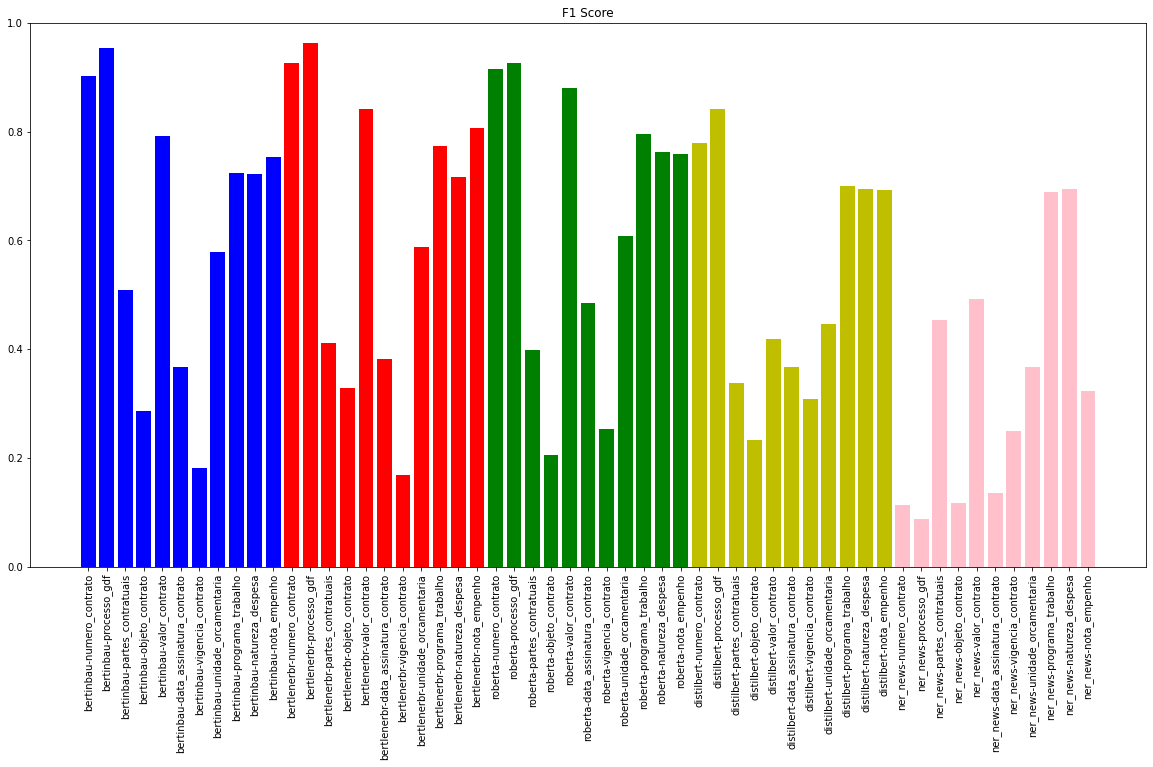

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9018324607329844, 0.9543624161073826, 0.5081539465101109, 0.2853894258101194, 0.7912772585669783, 0.3677884615384615, 0.1811646297627606, 0.5789473684210525, 0.7245696400625977, 0.7217573221757322, 0.7532258064516127, 0.9263721552878179, 0.9638554216867471, 0.41065171688857743, 0.328973185088293, 0.8409090909090909, 0.3814180929095354, 0.16888577435178698, 0.5879629629629629, 0.7734724292101341, 0.7166666666666667, 0.8059006211180125, 0.9155495978552278, 0.9262187088274045, 0.39882352941176474, 0.20456905503634476, 0.8796791443850268, 0.4840085287846482, 0.25284339457567806, 0.6082089552238806, 0.7964743589743589, 0.7617107942973524, 0.7581168831168831, 0.7792397660818714, 0.8409387222946544, 0.3369704749679075

Text(0.5, 1.0, 'F1 Score')

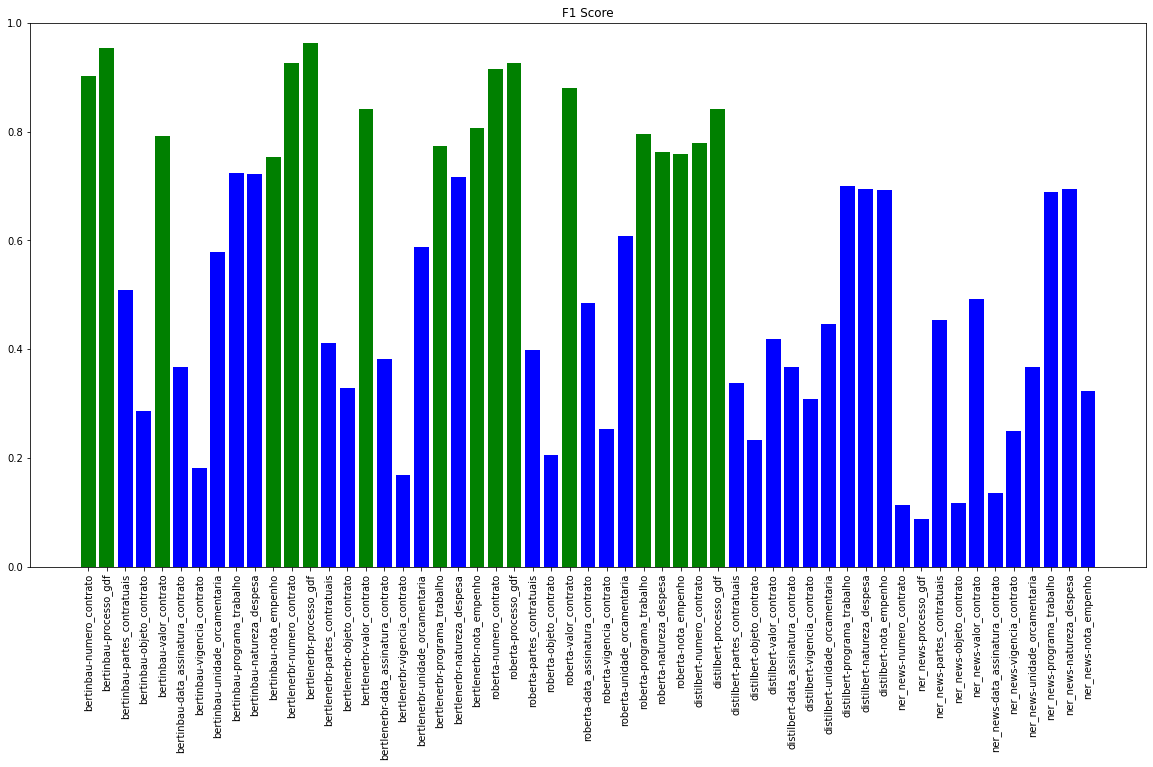

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*55

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


## Avaliando outputs dos modelos com dados de teste SETE ENTIDADES:

### Avaliando

In [ ]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE', 'partes_contratuais'), ('COOP . BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'par

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (CODEPLAN, partes...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (00121.00000.0137...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(-, partes_contratuais), (00121.00000.0137/20...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (00367-0000040...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, processo_gdf), (00302-00001101/2021...   
4    [(00121.00000.0137/2021-58, processo_gdf), (CO...   
..                                                 ...   
375  [(045005/2021, processo_gdf), (00431-00020054/...   
376  [(45/2021, numero_contrato), (VISUAL INDUSTRIA...   
377  [(43.980/2021, numero_contrato), (040

In [ ]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 201,...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'processo_gdf', 'start': 47, 'end':...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'processo_gdf', 'start': 23, 'end':...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()
# from nervaluate import Evaluator
# def evaluate(df:pd.DataFrame, true:str, pred:str):
#     return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
#                             'partes_contratuais',
#                             'natureza_despesa',
#                             'nota_empenho',
#                             'numero_contrato',
#                             'objeto_contrato',
#                             'processo_gdf',
#                             'programa_trabalho',
#                             'unidade_orcamentaria',
#                             'valor_contrato',
#                             'vigencia_contrato']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 1682,
    'incorrect': 8,
    'partial': 0,
    'missed': 769,
    'spurious': 96,
    'possible': 2459,
    'actual': 1786,
    'precision': 0.9417693169092946,
    'recall': 0.684017893452623,
    'f1': 0.7924617196702002},
   'partial': {'correct': 1605,
    'incorrect': 0,
    'partial': 85,
    'missed': 769,
    'spurious': 96,
    'possible': 2459,
    'actual': 1786,
    'precision': 0.9224524076147816,
    'recall': 0.6699877999186661,
    'f1': 0.7762073027090696},
   'strict': {'correct': 1599,
    'incorrect': 91,
    'partial': 0,
    'missed': 769,
    'spurious': 96,
    'possible': 2459,
    'actual': 1786,
    'precision': 0.8952967525195968,
    'recall': 0.6502643350955674,
    'f1': 0.753356890459364},
   'exact': {'correct': 1605,
    'incorrect': 85,
    'partial': 0,
    'missed': 769,
    'spurious': 96,
    'possible': 2459,
    'actual': 1786,
    'precision': 0.8986562150055991,
    'recall': 0.6527043513623424,
    'f1

### Teste 1:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.7762073027090696, 0.8151396261250865, 0.798960921617348, 0.6644225789746244, 0]


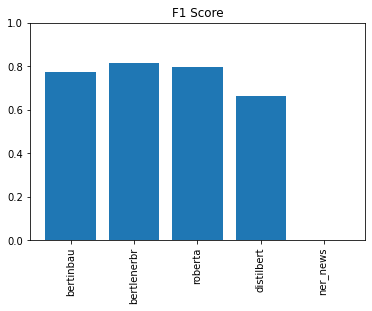

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_2['GPT-3'] = y

### test 2


['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0.9018324607329844, 0.955223880597015, 0.7376490630323679, 0.5543478260869565, 0.6971153846153847, 0.7038626609442061, 0.742998352553542, 0.9250334672021419, 0.9597855227882037, 0.8333333333333333, 0.5533980582524272, 0.7658610271903322, 0.7033898305084746, 0.8015625, 0.913978494623656, 0.9222520107238605, 0.8685636856368564, 0.562015503875969, 0.7566225165562914, 0.731404958677686, 0.7176470588235294, 0.7719298245614035, 0.8364116094986808, 0.40576496674057655, 0.39841688654353563, 0.6642857142857144, 0.6644591611479028, 0.6880415944540729, 0, 0, 0, 0, 0, 0, 0]


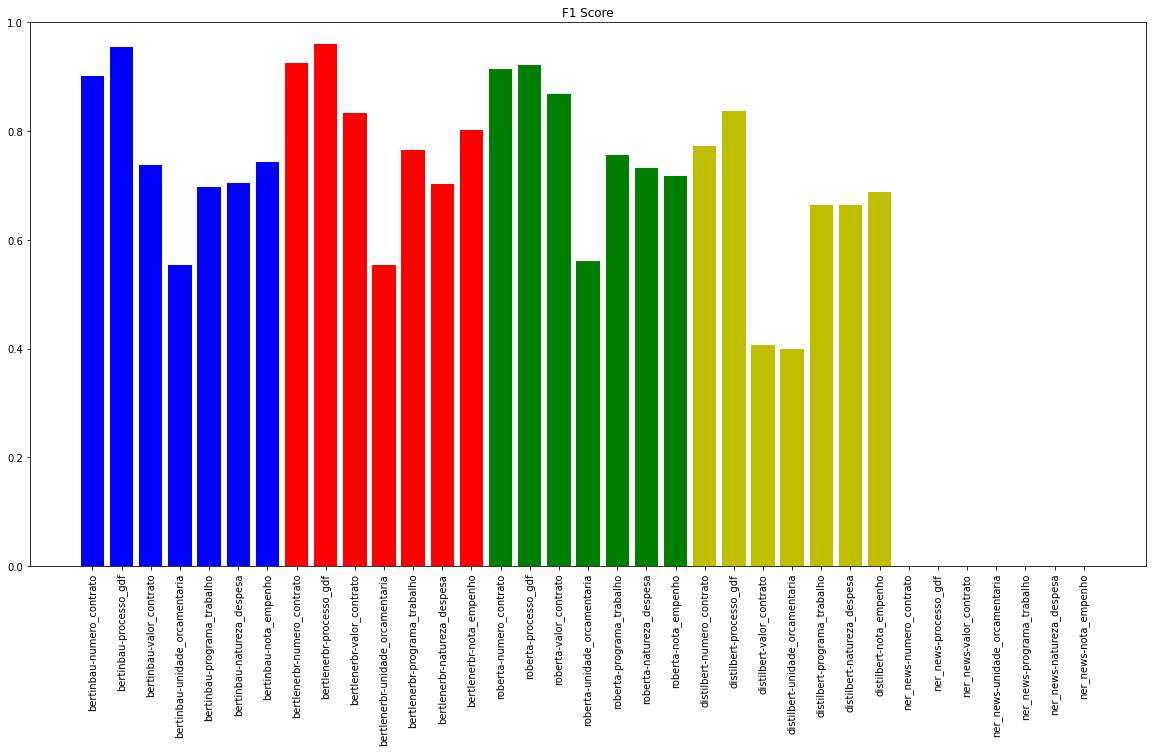

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(bestEntidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in bestEntidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in bestEntidadesExtratoContrato]

colors = ['b']*7 +['r']*7 +['g']*7 +['y']*7 + ['pink']*7

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0.9018324607329844, 0.955223880597015, 0.7376490630323679, 0.5543478260869565, 0.6971153846153847, 0.7038626609442061, 0.742998352553542, 0.9250334672021419, 0.9597855227882037, 0.8333333333333333, 0.5533980582524272, 0.7658610271903322, 0.7033898305084746, 0.8015625, 0.913978494623656, 0.9222520107238605, 0.8685636856368564, 0.562015503875969, 0.7566225165562914, 0.731404958677686, 0.7176470588235294, 0.7719298245614035, 0.8364116094986808, 0.40576496674057655, 0.39841688654353563, 0.6642857142857144, 0.6644591611479028, 0.6880415944540729, 0, 0, 0, 0, 0, 0, 0]
['bertinbau-numero_contrato', 'bertinbau-processo_gdf', 'bertlenerbr-numero_contrato', 'bertlenerbr-processo_gdf', 'bertlenerbr-valor_contrato', 'bertlenerbr-programa_trabalho', 'bertlenerbr-nota_empenho', 'roberta-numero_contrato', 

Text(0.5, 1.0, 'F1 Score')

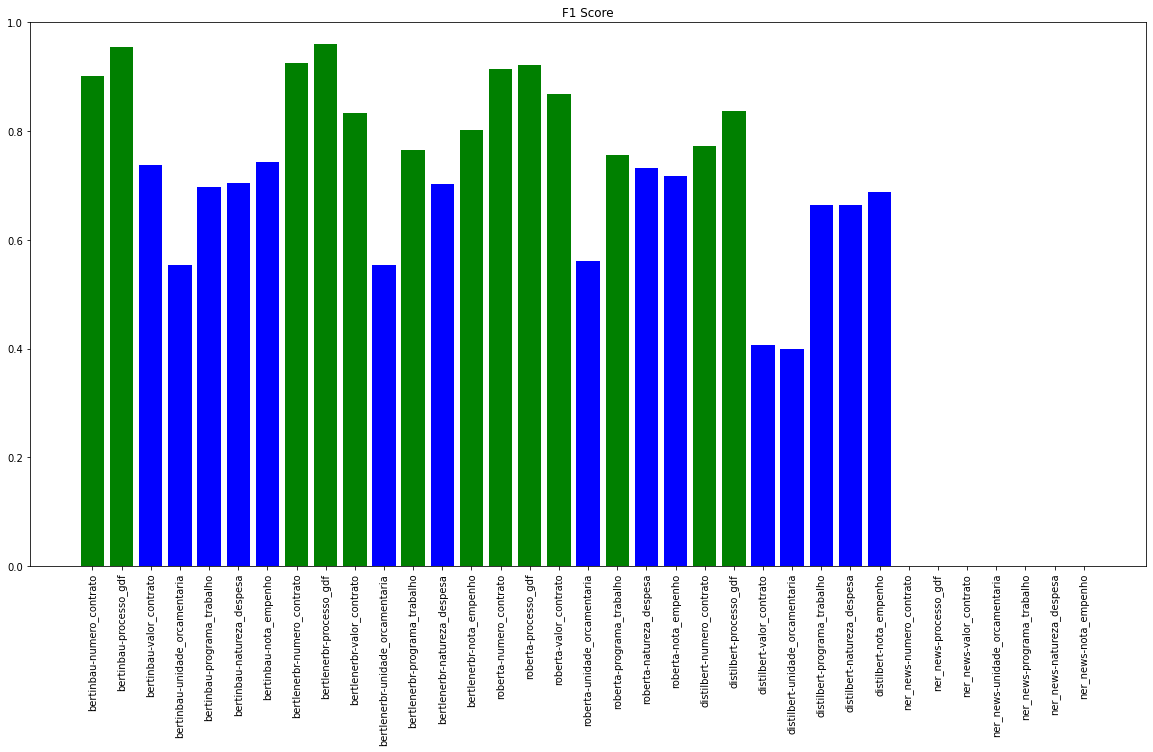

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(bestEntidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in bestEntidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in bestEntidadesExtratoContrato]

colors = ['b']*35

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


#WEAKSUP

## SALVANDO PICKLE

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/SavesFinal/t3/dict_ner_news.pkl", "rb") as f:
    dict_ner_news = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t3/dict_bertlenerbr.pkl", "rb") as f:
    dict_bertlenerbr = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t3/dict_distilbert.pkl", "rb") as f:
    dict_distilbert = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t3/dict_portuguese.pkl", "rb") as f:
    dict_portuguese = pkl.load(f)

with open("/content/drive/MyDrive/SavesFinal/t3/dict_roberta.pkl", "rb") as f:
    dict_roberta = pkl.load(f)
 

## Avaliando outputs dos modelos com dados de teste TODAS ENTIDADES:

### Avaliando

In [ ]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]


def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE ASSIST', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PREST

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (Pa...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (00121.00000.0137...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(o, partes_contratuais), (Nacional, partes_co...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Aprendizagem Ind...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (140/2021, nu...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [ ]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 40, ...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 3289,
    'incorrect': 92,
    'partial': 0,
    'missed': 1008,
    'spurious': 624,
    'possible': 4389,
    'actual': 4005,
    'precision': 0.8212234706616729,
    'recall': 0.7493734335839599,
    'f1': 0.7836549916607101},
   'partial': {'correct': 2526,
    'incorrect': 0,
    'partial': 855,
    'missed': 1008,
    'spurious': 624,
    'possible': 4389,
    'actual': 4005,
    'precision': 0.7374531835205993,
    'recall': 0.6729323308270677,
    'f1': 0.7037169406719086},
   'strict': {'correct': 2466,
    'incorrect': 915,
    'partial': 0,
    'missed': 1008,
    'spurious': 624,
    'possible': 4389,
    'actual': 4005,
    'precision': 0.6157303370786517,
    'recall': 0.5618591934381408,
    'f1': 0.5875625446747678},
   'exact': {'correct': 2526,
    'incorrect': 855,
    'partial': 0,
    'missed': 1008,
    'spurious': 624,
    'possible': 4389,
    'actual': 4005,
    'precision': 0.6307116104868914,
    'recall': 0.57552973342

### Teste 1:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.7037169406719086, 0.6769669327251995, 0.6748563056463429, 0.664632715325041, 0.4136567642658688]


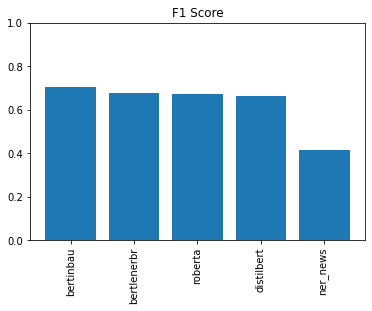

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_1['WeakSup'] = y 

### test 2


['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9396662387676509, 0.9497354497354498, 0.3014018691588785, 0.507936507936508, 0.871824480369515, 0.556701030927835, 0.5484311050477491, 0.7737881508078995, 0.8958031837916064, 0.8804347826086957, 0.8711566617862371, 0.94529262086514, 0.9614873837981408, 0.3222308288148722, 0.4091279543602282, 0.8670520231213873, 0.5441176470588235, 0.4903614457831325, 0.716887417218543, 0.8964028776978418, 0.8790613718411553, 0.86066763425254, 0.9075949367088607, 0.9637096774193549, 0.30712166172106825, 0.38232994526974196, 0.8678611422172452, 0.5689981096408319, 0.5529265255292651, 0.7732142857142857, 0.8998548621190131, 0.8503649635036497, 0.8869565217391303, 0.841645885286783, 0.9393530997304583, 0.3026222537207654, 0.4912451

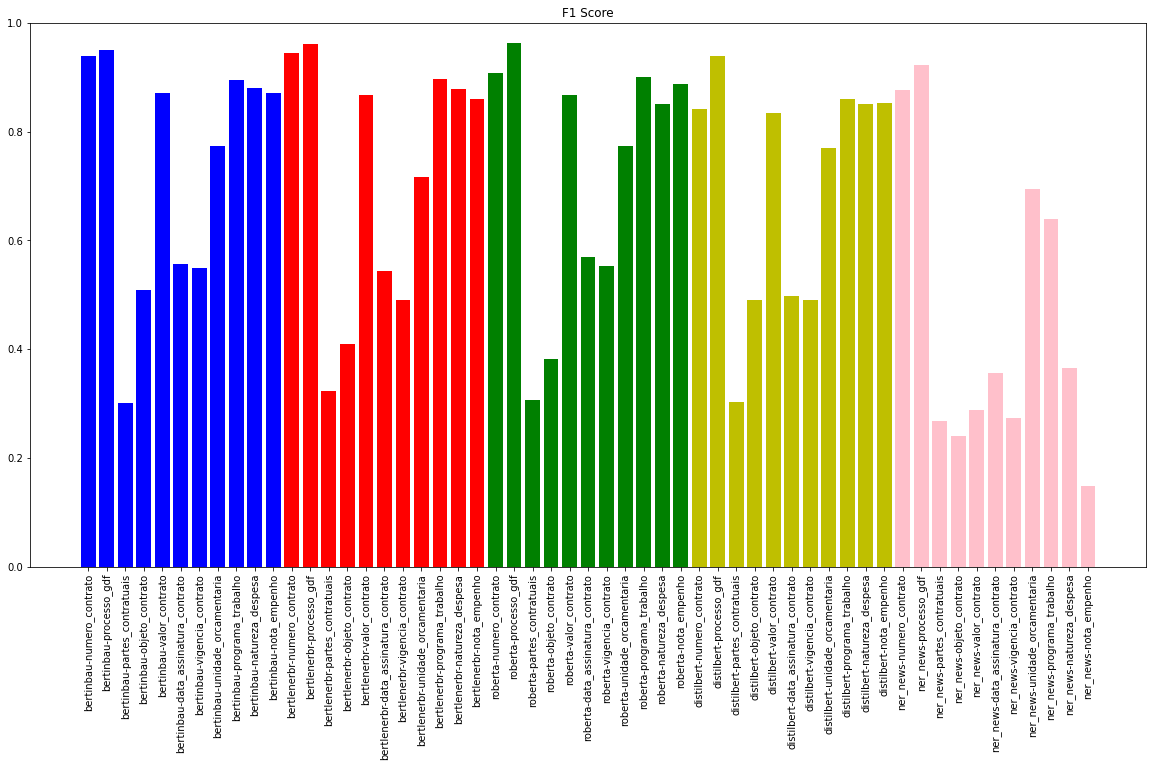

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9396662387676509, 0.9497354497354498, 0.3014018691588785, 0.507936507936508, 0.871824480369515, 0.556701030927835, 0.5484311050477491, 0.7737881508078995, 0.8958031837916064, 0.8804347826086957, 0.8711566617862371, 0.94529262086514, 0.9614873837981408, 0.3222308288148722, 0.4091279543602282, 0.8670520231213873, 0.5441176470588235, 0.4903614457831325, 0.716887417218543, 0.8964028776978418, 0.8790613718411553, 0.86066763425254, 0.9075949367088607, 0.9637096774193549, 0.30712166172106825, 0.38232994526974196, 0.8678611422172452, 0.5689981096408319, 0.5529265255292651, 0.7732142857142857, 0.8998548621190131, 0.8503649635036497, 0.8869565217391303, 0.841645885286783, 0.9393530997304583, 0.3026222537207654, 0.4912451

Text(0.5, 1.0, 'F1 Score')

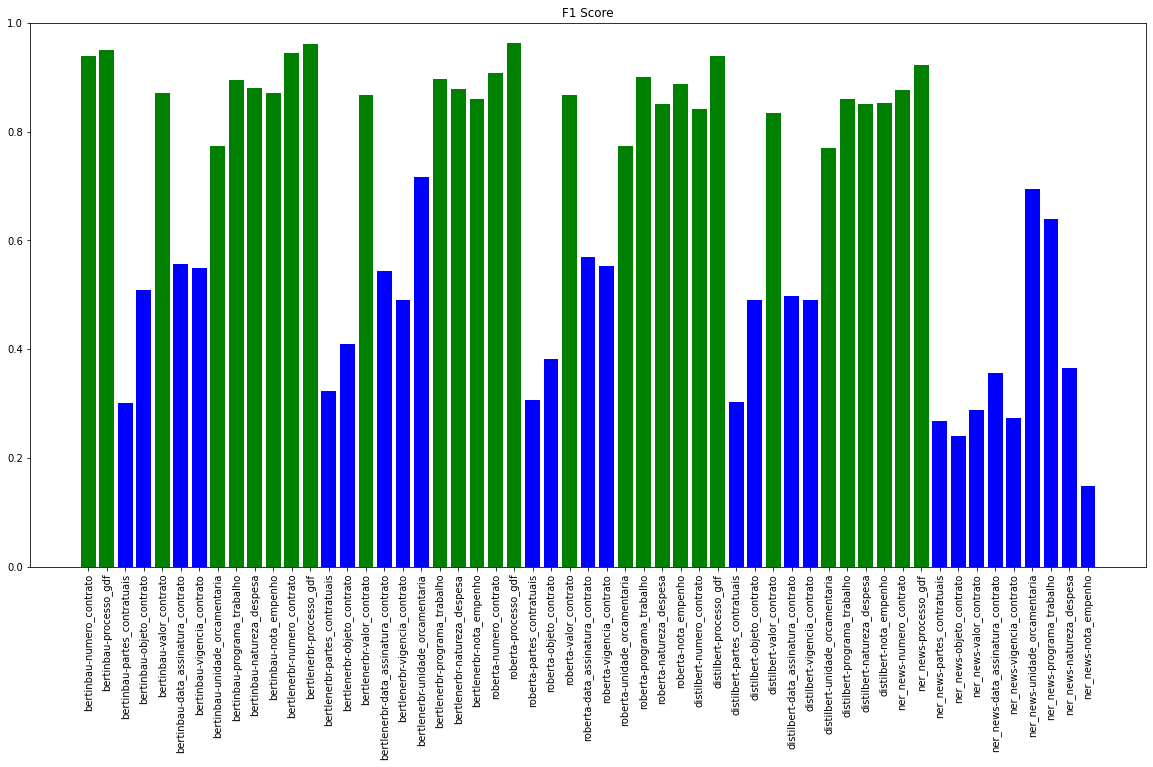

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*55

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


## Avaliando outputs dos modelos com dados de teste SETE ENTIDADES:

### Avaliando

In [ ]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE ASSIST', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PREST

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (Pa...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (00121.00000.0137...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(o, partes_contratuais), (Nacional, partes_co...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Aprendizagem Ind...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (140/2021, nu...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [ ]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 40, ...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()
# from nervaluate import Evaluator
# def evaluate(df:pd.DataFrame, true:str, pred:str):
#     return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
#                             'partes_contratuais',
#                             'natureza_despesa',
#                             'nota_empenho',
#                             'numero_contrato',
#                             'objeto_contrato',
#                             'processo_gdf',
#                             'programa_trabalho',
#                             'unidade_orcamentaria',
#                             'valor_contrato',
#                             'vigencia_contrato']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 2157,
    'incorrect': 57,
    'partial': 0,
    'missed': 298,
    'spurious': 159,
    'possible': 2512,
    'actual': 2373,
    'precision': 0.9089759797724399,
    'recall': 0.8586783439490446,
    'f1': 0.8831115660184238},
   'partial': {'correct': 2119,
    'incorrect': 0,
    'partial': 95,
    'missed': 298,
    'spurious': 159,
    'possible': 2512,
    'actual': 2373,
    'precision': 0.9129793510324484,
    'recall': 0.8624601910828026,
    'f1': 0.8870010235414536},
   'strict': {'correct': 2063,
    'incorrect': 151,
    'partial': 0,
    'missed': 298,
    'spurious': 159,
    'possible': 2512,
    'actual': 2373,
    'precision': 0.8693636746734091,
    'recall': 0.8212579617834395,
    'f1': 0.8446264073694983},
   'exact': {'correct': 2119,
    'incorrect': 95,
    'partial': 0,
    'missed': 298,
    'spurious': 159,
    'possible': 2512,
    'actual': 2373,
    'precision': 0.8929624947324062,
    'recall': 0.8435509554140127,

### Teste 1:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.8870010235414536, 0.8786958282705549, 0.8818015080497249, 0.8476230018683828, 0.5820812465219811]


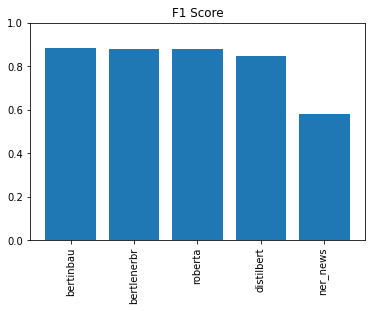

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_2['WeakSup'] = y

### test 2


['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0.9384615384615386, 0.9472295514511874, 0.8705202312138729, 0.7737881508078995, 0.8958031837916064, 0.8802177858439202, 0.8711566617862371, 0.9438775510204082, 0.9612817089452603, 0.8627450980392157, 0.716887417218543, 0.8962536023054755, 0.8790613718411553, 0.8586005830903789, 0.9045801526717557, 0.9623655913978494, 0.8656215005599104, 0.7732142857142857, 0.8998548621190131, 0.8500914076782449, 0.8851744186046512, 0.8387499999999999, 0.9389416553595658, 0.8337236533957846, 0.7690875232774673, 0.8318713450292398, 0.8511029411764706, 0.8517397881996973, 0.8634538152610443, 0.8999999999999999, 0.021276595744680854, 0.6141176470588234, 0.6321626617375231, 0.3157894736842105, 0.1386138613861386]


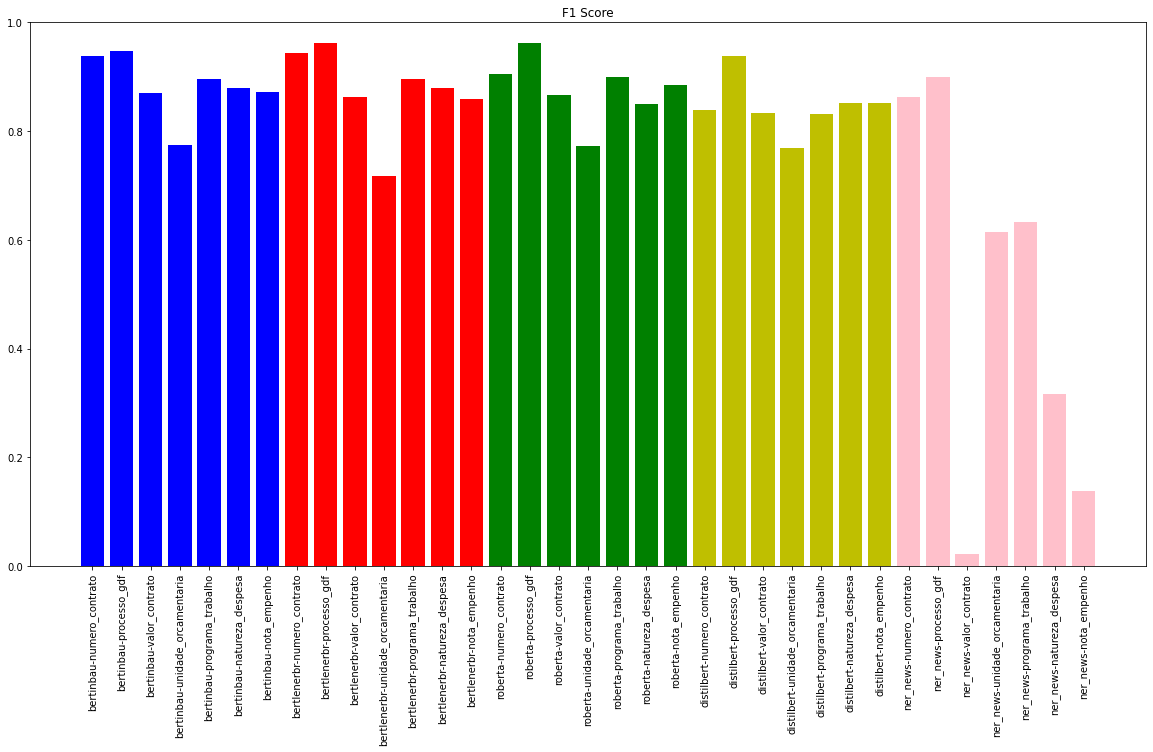

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(bestEntidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in bestEntidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in bestEntidadesExtratoContrato]

colors = ['b']*7 +['r']*7 +['g']*7 +['y']*7 + ['pink']*7

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0.9384615384615386, 0.9472295514511874, 0.8705202312138729, 0.7737881508078995, 0.8958031837916064, 0.8802177858439202, 0.8711566617862371, 0.9438775510204082, 0.9612817089452603, 0.8627450980392157, 0.716887417218543, 0.8962536023054755, 0.8790613718411553, 0.8586005830903789, 0.9045801526717557, 0.9623655913978494, 0.8656215005599104, 0.7732142857142857, 0.8998548621190131, 0.8500914076782449, 0.8851744186046512, 0.8387499999999999, 0.9389416553595658, 0.8337236533957846, 0.7690875232774673, 0.8318713450292398, 0.8511029411764706, 0.8517397881996973, 0.8634538152610443, 0.8999999999999999, 0.021276595744680854, 0.6141176470588234, 0.6321626617375231, 0.3157894736842105, 0.1386138613861386]
['bertinbau-numero_contrato', 'bertinbau-processo_gdf', 'bertinbau-valor_contrato', 'bertinbau-unidad

Text(0.5, 1.0, 'F1 Score')

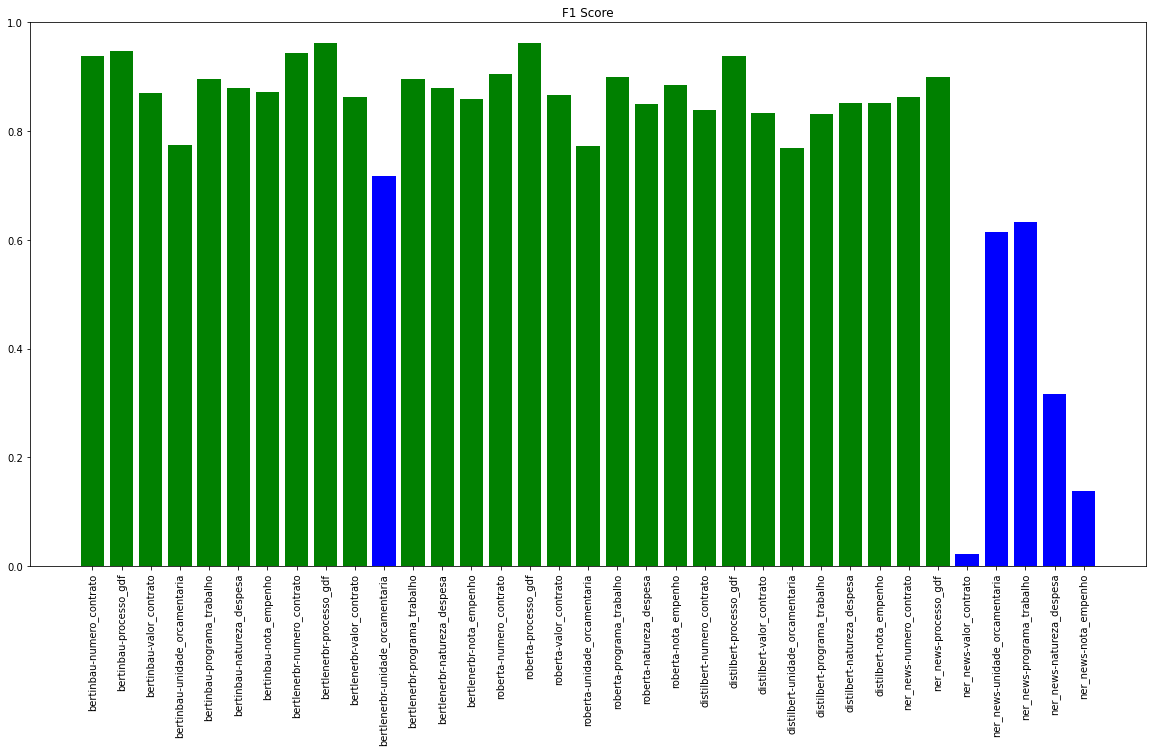

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(bestEntidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in bestEntidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in bestEntidadesExtratoContrato]

colors = ['b']*35

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


#HUMAN

## SALVANDO PICKLE

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/SavesFinal/t2/dict_ner_news.pkl", "rb") as f:
    dict_ner_news = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t2/dict_bertlenerbr.pkl", "rb") as f:
    dict_bertlenerbr = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t2/dict_distilbert.pkl", "rb") as f:
    dict_distilbert = pkl.load(f)
 
with open("/content/drive/MyDrive/SavesFinal/t2/dict_portuguese.pkl", "rb") as f:
    dict_portuguese = pkl.load(f)

with open("/content/drive/MyDrive/SavesFinal/t2/dict_roberta.pkl", "rb") as f:
    dict_roberta = pkl.load(f)
 

## Avaliando outputs dos modelos com dados de teste TODAS ENTIDADES:

### Avaliando

In [ ]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]


def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE ASSIST . À SAÚDE DOS SERV . DO DF INAS', 'partes_contratuais'), ('COOP', 'parte

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (204/2021, numer...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (140/2021, nu...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [ ]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 3590,
    'incorrect': 74,
    'partial': 0,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.8224513172966781,
    'recall': 0.8235833906859371,
    'f1': 0.823016964695094},
   'partial': {'correct': 2928,
    'incorrect': 0,
    'partial': 736,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.7550973654066437,
    'recall': 0.7561367286074788,
    'f1': 0.7556166895919303},
   'strict': {'correct': 2896,
    'incorrect': 768,
    'partial': 0,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.663459335624284,
    'recall': 0.6643725625143382,
    'f1': 0.6639156350298028},
   'exact': {'correct': 2928,
    'incorrect': 736,
    'partial': 0,
    'missed': 695,
    'spurious': 701,
    'possible': 4359,
    'actual': 4365,
    'precision': 0.6707903780068728,
    'recall': 0.6717136958017894,

### Teste 1:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.7556166895919303, 0.7611569314201787, 0.7071053477655128, 0.631984585741811, 0.5515314106863403]


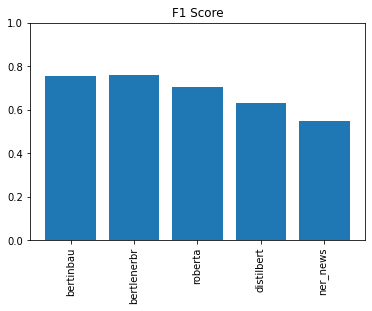

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_1['Humano'] = y 

### test 2


['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9630512514898689, 0.9588859416445623, 0.6722428748451053, 0.48754789272030646, 0.876632801161103, 0.5413385826771653, 0.5160462130937099, 0.7924187725631769, 0.9126637554585154, 0.8996478873239436, 0.8851744186046512, 0.9587264150943396, 0.9680851063829786, 0.6509988249118683, 0.5650406504065041, 0.8850267379679144, 0.5613682092555332, 0.4663278271918678, 0.7911504424778761, 0.9127324749642346, 0.9092495636998255, 0.8879310344827586, 0.9168564920273349, 0.9627163781624501, 0.4691762138570649, 0.45641447368421056, 0.8890374331550802, 0.6263157894736843, 0.5024630541871922, 0.7943262411347518, 0.9107913669064749, 0.9066901408450704, 0.9037356321839081, 0.8540540540540541, 0.8478581979320532, 0.5310633213859021, 0

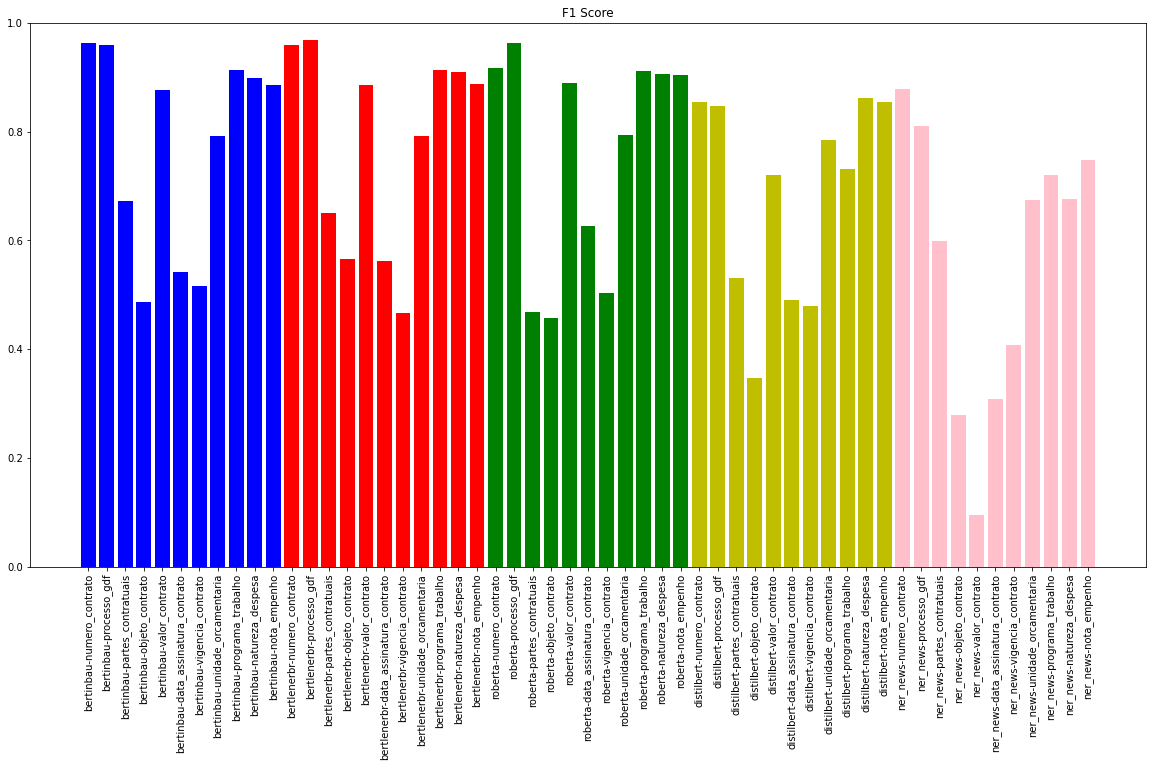

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[0.9630512514898689, 0.9588859416445623, 0.6722428748451053, 0.48754789272030646, 0.876632801161103, 0.5413385826771653, 0.5160462130937099, 0.7924187725631769, 0.9126637554585154, 0.8996478873239436, 0.8851744186046512, 0.9587264150943396, 0.9680851063829786, 0.6509988249118683, 0.5650406504065041, 0.8850267379679144, 0.5613682092555332, 0.4663278271918678, 0.7911504424778761, 0.9127324749642346, 0.9092495636998255, 0.8879310344827586, 0.9168564920273349, 0.9627163781624501, 0.4691762138570649, 0.45641447368421056, 0.8890374331550802, 0.6263157894736843, 0.5024630541871922, 0.7943262411347518, 0.9107913669064749, 0.9066901408450704, 0.9037356321839081, 0.8540540540540541, 0.8478581979320532, 0.5310633213859021, 0

Text(0.5, 1.0, 'F1 Score')

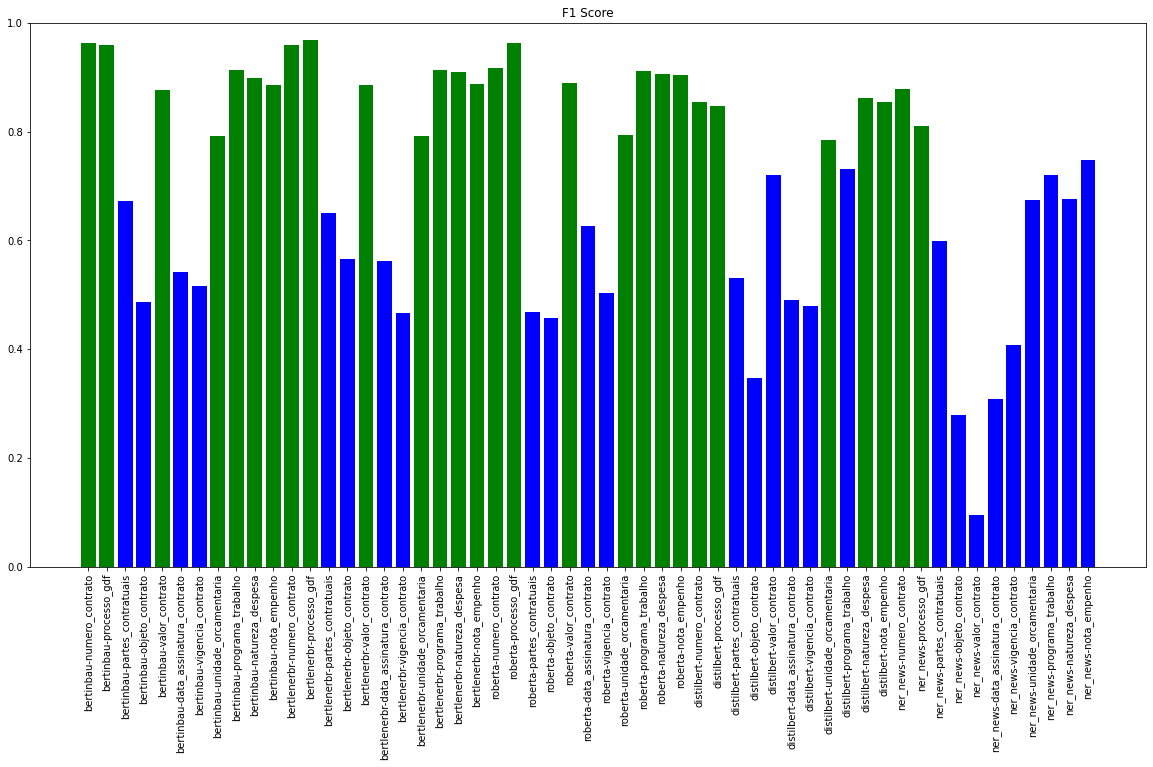

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*55

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


## Avaliando outputs dos modelos com dados de teste SETE ENTIDADES:

### Avaliando

In [ ]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE ASSIST . À SAÚDE DOS SERV . DO DF INAS', 'partes_contratuais'), ('COOP', 'parte

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (204/2021, numer...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (140/2021, nu...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [ ]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()
# from nervaluate import Evaluator
# def evaluate(df:pd.DataFrame, true:str, pred:str):
#     return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
#                             'partes_contratuais',
#                             'natureza_despesa',
#                             'nota_empenho',
#                             'numero_contrato',
#                             'objeto_contrato',
#                             'processo_gdf',
#                             'programa_trabalho',
#                             'unidade_orcamentaria',
#                             'valor_contrato',
#                             'vigencia_contrato']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau': ({'ent_type': {'correct': 2179,
    'incorrect': 29,
    'partial': 0,
    'missed': 274,
    'spurious': 93,
    'possible': 2482,
    'actual': 2301,
    'precision': 0.9469795740982182,
    'recall': 0.8779210314262691,
    'f1': 0.9111436337026969},
   'partial': {'correct': 2111,
    'incorrect': 0,
    'partial': 97,
    'missed': 274,
    'spurious': 93,
    'possible': 2482,
    'actual': 2301,
    'precision': 0.9385049978270317,
    'recall': 0.8700644641418211,
    'f1': 0.9029897553836504},
   'strict': {'correct': 2085,
    'incorrect': 123,
    'partial': 0,
    'missed': 274,
    'spurious': 93,
    'possible': 2482,
    'actual': 2301,
    'precision': 0.9061277705345502,
    'recall': 0.8400483481063659,
    'f1': 0.8718377587288314},
   'exact': {'correct': 2111,
    'incorrect': 97,
    'partial': 0,
    'missed': 274,
    'spurious': 93,
    'possible': 2482,
    'actual': 2301,
    'precision': 0.9174272055627988,
    'recall': 0.8505237711522965,
   

### Teste 1:

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.9029897553836504, 0.9060705496308449, 0.8992849846782431, 0.8040063737764627, 0.6958119030124906]


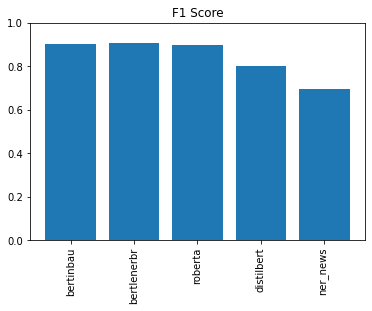

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_2['Humano'] = y

### test 2


['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0.9619047619047618, 0.9562913907284767, 0.8751814223512336, 0.7924187725631769, 0.9126637554585154, 0.8964912280701754, 0.8851744186046512, 0.9574970484061393, 0.9667110519307589, 0.8821954484605087, 0.7897526501766784, 0.9126074498567336, 0.9092495636998255, 0.8890489913544668, 0.9093997734994337, 0.9610738255033556, 0.8877005347593583, 0.7939609236234457, 0.9106628242074928, 0.9066901408450704, 0.9005763688760806, 0.8521031207598371, 0.8392857142857143, 0.7115689381933439, 0.7838827838827839, 0.7213114754098361, 0.862708719851577, 0.8480243161094225, 0.8772169167803547, 0.7990815154994261, 0.033426183844011144, 0.660377358490566, 0.7184801381692573, 0.6622222222222223, 0.750814332247557]


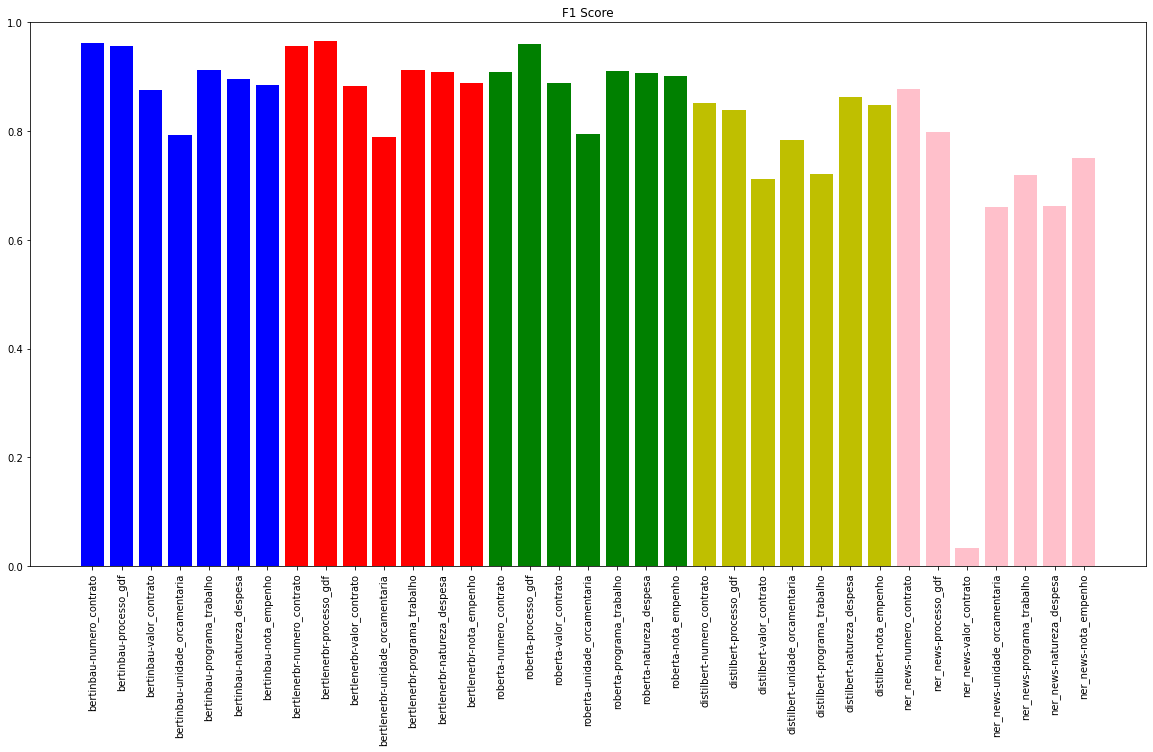

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(bestEntidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in bestEntidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in bestEntidadesExtratoContrato]

colors = ['b']*7 +['r']*7 +['g']*7 +['y']*7 + ['pink']*7

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0.9619047619047618, 0.9562913907284767, 0.8751814223512336, 0.7924187725631769, 0.9126637554585154, 0.8964912280701754, 0.8851744186046512, 0.9574970484061393, 0.9667110519307589, 0.8821954484605087, 0.7897526501766784, 0.9126074498567336, 0.9092495636998255, 0.8890489913544668, 0.9093997734994337, 0.9610738255033556, 0.8877005347593583, 0.7939609236234457, 0.9106628242074928, 0.9066901408450704, 0.9005763688760806, 0.8521031207598371, 0.8392857142857143, 0.7115689381933439, 0.7838827838827839, 0.7213114754098361, 0.862708719851577, 0.8480243161094225, 0.8772169167803547, 0.7990815154994261, 0.033426183844011144, 0.660377358490566, 0.7184801381692573, 0.6622222222222223, 0.750814332247557]
['bertinbau-numero_contrato', 'bertinbau-processo_gdf', 'bertinbau-valor_contrato', 'bertinbau-unidade_

Text(0.5, 1.0, 'F1 Score')

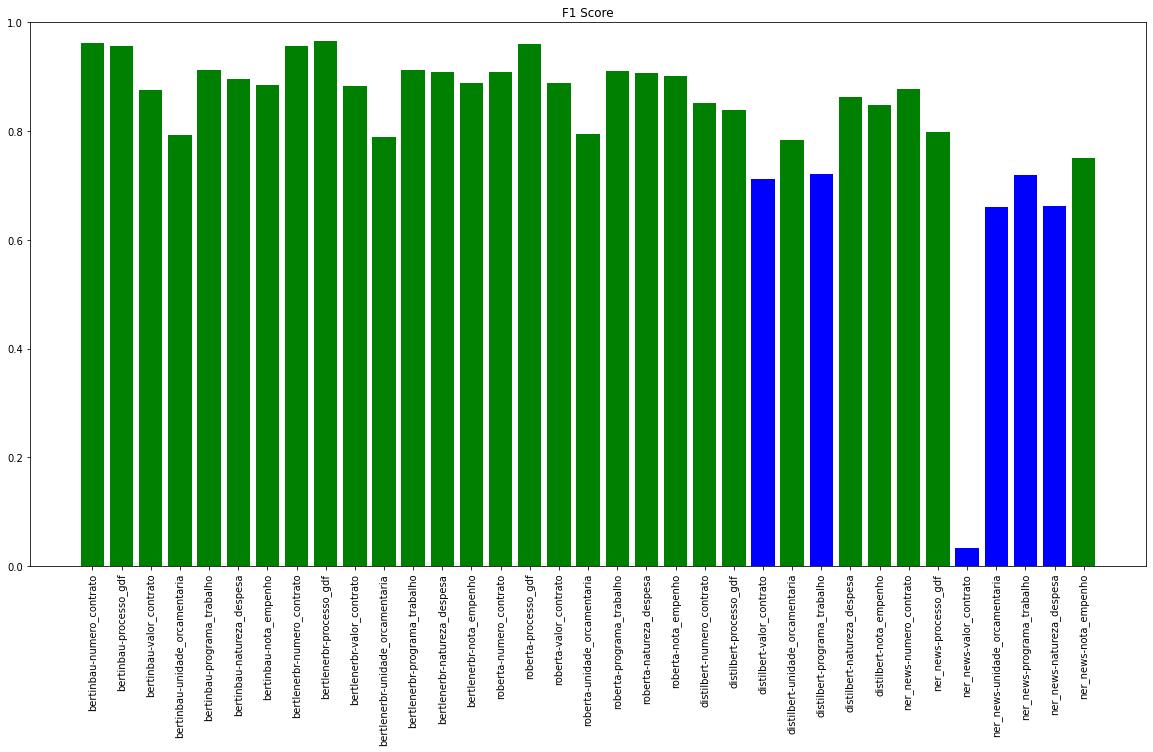

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(bestEntidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in bestEntidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in bestEntidadesExtratoContrato]

colors = ['b']*35

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


# Curves from Combining tests

## BERTINBAU

### pegando PKL

In [32]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bert_portuguese/dict_portuguese100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

### Aplicando

#### Avaliando

In [33]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [34]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [35]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [36]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [37]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('COOP . BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PE

In [38]:
df = pd.DataFrame()
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['10%'] = lista_spans[1]
df['20%'] = lista_spans[2]
df['30%'] = lista_spans[3]
df['40%'] = lista_spans[4]
df['50%'] = lista_spans[5]
df['60%'] = lista_spans[6]
df['70%'] = lista_spans[7]
df['80%'] = lista_spans[8]
df['90%'] = lista_spans[9]
df['100%'] = lista_spans[10]

In [39]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   10%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (-, partes_contra...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   20%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (BALTAZAR MOUR...   
2    [(204/2021, numero_contrato), (WAYNER, partes_...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (-, partes_contra...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (SECRETARIA, ...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   30%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia de Pla...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   40%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (de Planejamento ...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [40]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   10%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   20%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   30%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   40%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

#### Teste 1:

In [41]:
# from nervaluate import Evaluator
# def evaluate(df:pd.DataFrame, true:str, pred:str):
#     return Evaluator(df[true].values, df[pred].values, tags=[
#                                 'numero_contrato',
#                                 'processo_gdf',
#                                 'valor_contrato',
#                                 'unidade_orcamentaria',
#                                 'programa_trabalho',
#                                 'nota_empenho',
#                                 'natureza_despesa',]).evaluate()
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [42]:
metrics1 = {}
for c in spans.columns[2:]:
    metrics1[c] = evaluate(spans, 'annotation', c)
#metrics1

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5536114849708389, 0.5624077228847245, 0.6776308478719858, 0.6699146047733743, 0.5884232518127074, 0.6560800522079617, 0.718913503283981, 0.6956844449157036, 0.7132782369146006, 0.7451933701657458]


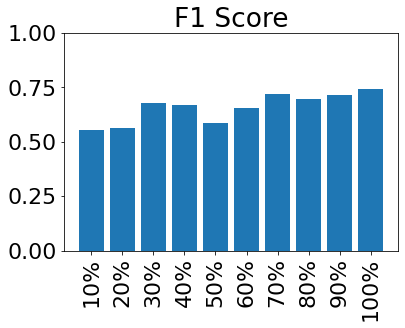

In [43]:
import matplotlib.pyplot as plt
xticks = list(metrics1.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics1[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5536114849708389, 0.5624077228847245, 0.6776308478719858, 0.6699146047733743, 0.5884232518127074, 0.6560800522079617, 0.718913503283981, 0.6956844449157036, 0.7132782369146006, 0.7451933701657458]


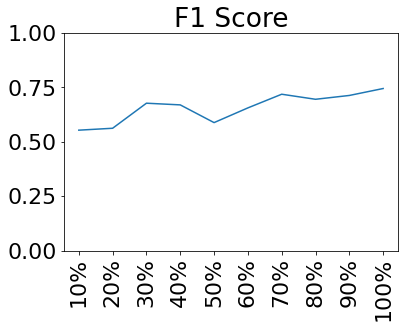

In [44]:
import matplotlib.pyplot as plt
xticks = list(metrics1.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics1[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [45]:
fig_3['Bertimbau'] = y

#### Teste 2:

In [46]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()
# from nervaluate import Evaluator
# def evaluate(df:pd.DataFrame, true:str, pred:str):
#     return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
#                             'partes_contratuais',
#                             'natureza_despesa',
#                             'nota_empenho',
#                             'numero_contrato',
#                             'objeto_contrato',
#                             'processo_gdf',
#                             'programa_trabalho',
#                             'unidade_orcamentaria',
#                             'valor_contrato',
#                             'vigencia_contrato']).evaluate()

In [47]:
metrics12 = {}
for c in spans.columns[2:]:
    metrics12[c] = evaluate(spans, 'annotation', c)
# metrics

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7693798449612403, 0.7698795180722893, 0.8718227243102323, 0.8664236706689536, 0.7963272120200333, 0.863546905751148, 0.8912310286677909, 0.8781852082038534, 0.8830372250423012, 0.8967345207803222]


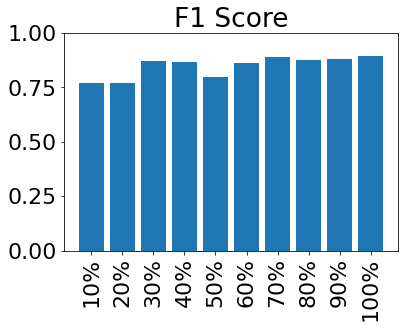

In [48]:
import matplotlib.pyplot as plt
xticks = list(metrics12.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics12[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7693798449612403, 0.7698795180722893, 0.8718227243102323, 0.8664236706689536, 0.7963272120200333, 0.863546905751148, 0.8912310286677909, 0.8781852082038534, 0.8830372250423012, 0.8967345207803222]


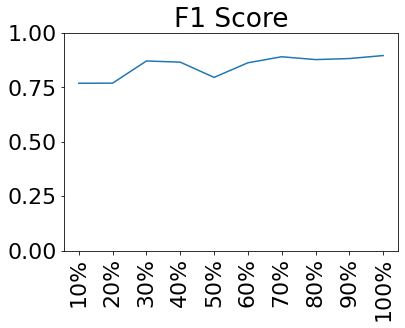

In [49]:
import matplotlib.pyplot as plt
xticks = list(metrics12.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics12[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [50]:
fig_3_1['Bertimbau'] = y

## Bertlener

### pegando PKL

In [51]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/bertlener/dict_bertlener100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

### Aplicando:

#### Avaliando

In [52]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [53]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [54]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [55]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [56]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO', 'partes_contratuais'), ('DO DF', 'partes_contratuais'), ('COOP . BRASILIENSE DOS

In [57]:
df = pd.DataFrame()
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['10%'] = lista_spans[1]
df['20%'] = lista_spans[2]
df['30%'] = lista_spans[3]
df['40%'] = lista_spans[4]
df['50%'] = lista_spans[5]
df['60%'] = lista_spans[6]
df['70%'] = lista_spans[7]
df['80%'] = lista_spans[8]
df['90%'] = lista_spans[9]
df['100%'] = lista_spans[10]

In [58]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   10%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (CODEPLAN, partes...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   20%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(CODEPLAN, partes_contratuais), (00121.00000....   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   30%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia, parte...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(04001-0000000245/2021-20, processo_gdf), (IN...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   40%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (-, partes_contra...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [59]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   10%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   20%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'partes_contratuais', 'start': 144,...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   30%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'processo_gdf', 'start': 45, 'end':...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   40%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

#### Teste 1:

In [60]:
# from nervaluate import Evaluator
# def evaluate(df:pd.DataFrame, true:str, pred:str):
#     return Evaluator(df[true].values, df[pred].values, tags=[
#                                 'numero_contrato',
#                                 'processo_gdf',
#                                 'valor_contrato',
#                                 'unidade_orcamentaria',
#                                 'programa_trabalho',
#                                 'nota_empenho',
#                                 'natureza_despesa',]).evaluate()
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [61]:
metrics2 = {}
for c in spans.columns[2:]:
    metrics2[c] = evaluate(spans, 'annotation', c)
#metrics2

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5247326203208557, 0.5576989719302299, 0.6231728288907997, 0.5956917081619398, 0.6073090455112927, 0.6641281218501512, 0.6879865348201136, 0.7421087242437527, 0.6742741068227983, 0.724328685029388]


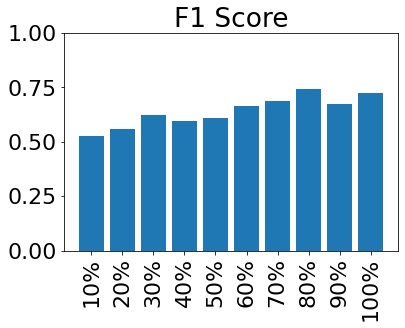

In [62]:
import matplotlib.pyplot as plt
xticks = list(metrics2.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics2[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5247326203208557, 0.5576989719302299, 0.6231728288907997, 0.5956917081619398, 0.6073090455112927, 0.6641281218501512, 0.6879865348201136, 0.7421087242437527, 0.6742741068227983, 0.724328685029388]


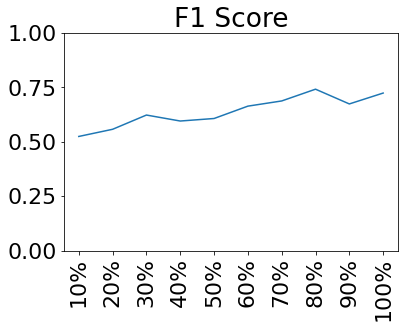

In [63]:
import matplotlib.pyplot as plt
xticks = list(metrics2.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics2[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [64]:
fig_3['Bertlener'] = y

#### Teste 2:

In [65]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()
# from nervaluate import Evaluator
# def evaluate(df:pd.DataFrame, true:str, pred:str):
#     return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
#                             'partes_contratuais',
#                             'natureza_despesa',
#                             'nota_empenho',
#                             'numero_contrato',
#                             'objeto_contrato',
#                             'processo_gdf',
#                             'programa_trabalho',
#                             'unidade_orcamentaria',
#                             'valor_contrato',
#                             'vigencia_contrato']).evaluate()

In [66]:
metrics22 = {}
for c in spans.columns[2:]:
    metrics22[c] = evaluate(spans, 'annotation', c)
# metrics

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7456445993031359, 0.7771567436208993, 0.8429227740100634, 0.8539549270879364, 0.8291503568961548, 0.8778761061946904, 0.8776758409785933, 0.8824611610793132, 0.8690053285968029, 0.8778906418845904]


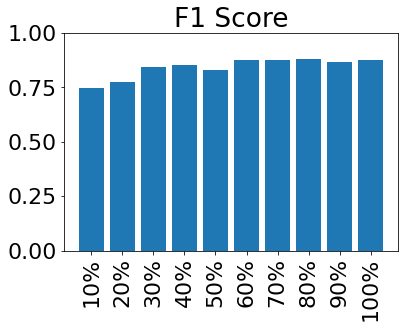

In [67]:
import matplotlib.pyplot as plt
xticks = list(metrics22.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics22[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7456445993031359, 0.7771567436208993, 0.8429227740100634, 0.8539549270879364, 0.8291503568961548, 0.8778761061946904, 0.8776758409785933, 0.8824611610793132, 0.8690053285968029, 0.8778906418845904]


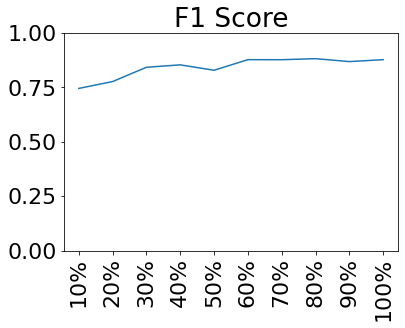

In [68]:
import matplotlib.pyplot as plt
xticks = list(metrics22.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics22[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [69]:
fig_3_1['Bertlener'] = y

## ROBERTA

### pegando PKL

In [70]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/roberta/dict_roberta100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

### Aplicando

#### Avaliando

In [71]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [72]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [73]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [74]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [75]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO 

In [76]:
df = pd.DataFrame()
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['10%'] = lista_spans[1]
df['20%'] = lista_spans[2]
df['30%'] = lista_spans[3]
df['40%'] = lista_spans[4]
df['50%'] = lista_spans[5]
df['60%'] = lista_spans[6]
df['70%'] = lista_spans[7]
df['80%'] = lista_spans[8]
df['90%'] = lista_spans[9]
df['100%'] = lista_spans[10]

In [77]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   10%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (00367-0000040...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (Co...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   20%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (204/2021, numer...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (CI...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   30%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (00367-0000040...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (DE...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   40%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (BALTAZAR, par...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (00121.00000.0137...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [78]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   10%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   20%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   30%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   40%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

#### Teste 1:

In [79]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [80]:
metrics3 = {}
for c in spans.columns[2:]:
    metrics3[c] = evaluate(spans, 'annotation', c)
#metrics3

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5001207146306133, 0.5116694701429774, 0.5409036860879906, 0.5815440840566468, 0.6610169491525425, 0.6771387638149816, 0.6251412139262605, 0.6772658446895955, 0.5848375451263538, 0.6837843833185447]


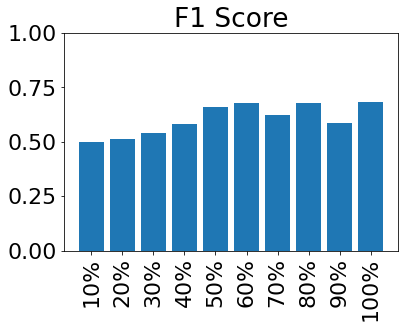

In [81]:
import matplotlib.pyplot as plt
xticks = list(metrics3.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics3[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5001207146306133, 0.5116694701429774, 0.5409036860879906, 0.5815440840566468, 0.6610169491525425, 0.6771387638149816, 0.6251412139262605, 0.6772658446895955, 0.5848375451263538, 0.6837843833185447]


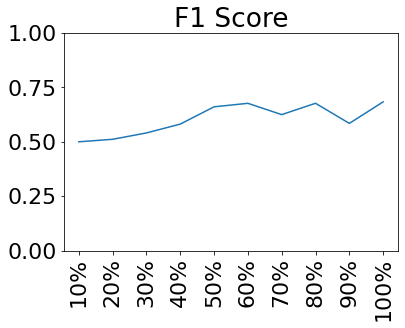

In [82]:
import matplotlib.pyplot as plt
xticks = list(metrics3.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics3[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [83]:
fig_3['Roberta'] = y

#### Teste 2:

In [84]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()

In [85]:
metrics32 = {}
for c in spans.columns[2:]:
    metrics32[c] = evaluate(spans, 'annotation', c)
# metrics

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7283574511297284, 0.7792207792207793, 0.7535055350553507, 0.789559925093633, 0.8669087801751761, 0.8761098492669833, 0.870953819594303, 0.880901287553648, 0.84735550100424, 0.8702974628171478]


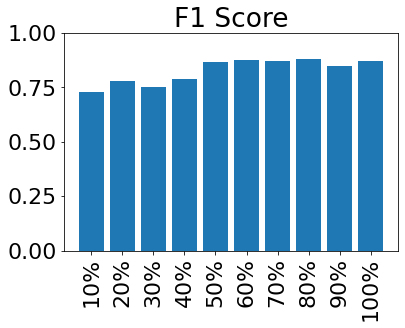

In [86]:
import matplotlib.pyplot as plt
xticks = list(metrics32.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics32[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7283574511297284, 0.7792207792207793, 0.7535055350553507, 0.789559925093633, 0.8669087801751761, 0.8761098492669833, 0.870953819594303, 0.880901287553648, 0.84735550100424, 0.8702974628171478]


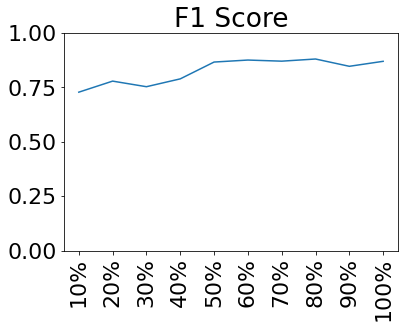

In [87]:
import matplotlib.pyplot as plt
xticks = list(metrics32.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics32[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [88]:
fig_3_1['Roberta'] = y

## Distilbert

### pegando PKL

In [89]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

### Aplicando

#### Avaliando

In [90]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'nota_empenho',
                                'natureza_despesa',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [91]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [92]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [93]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [94]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO', 'partes_contratuais'), ('INAS', 'partes_contratuais'), ('BRASILIENSE', 'partes_c

In [95]:
df = pd.DataFrame()
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['10%'] = lista_spans[1]
df['20%'] = lista_spans[2]
df['30%'] = lista_spans[3]
df['40%'] = lista_spans[4]
df['50%'] = lista_spans[5]
df['60%'] = lista_spans[6]
df['70%'] = lista_spans[7]
df['80%'] = lista_spans[8]
df['90%'] = lista_spans[9]
df['100%'] = lista_spans[10]

In [96]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   10%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (BALTAZAR, par...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (CIENTÍFICOS, par...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(SEAGRI/DF, partes_contratuais), (VISUAL INDU...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(SEEDF, partes_contratuais), (PRODUTOS PARA O...   

                                                   20%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (21.705.564/00...   
2    [(204/2021, numero_contrato), (TRISTÃO, partes...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (- SENAI/DF, part...   
..                                                 ...   
375  [(045005/2021, processo_gdf), (SECRETARIA, par...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   30%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia, parte...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                                   40%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (O,...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (SEAGRI/DF, parte...   
377  [(43.980/2021, numero_contrato), (040

In [97]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   10%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'partes_contratuais', 'start': 118,...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'partes_contratuais', 'start': 97, ...   

                                                   20%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'processo_gdf', 'start': 23, 'end':...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   30%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   40%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

#### Teste 1:

In [98]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [99]:
metrics4 = {}
for c in spans.columns[2:]:
    metrics4[c] = evaluate(spans, 'annotation', c)
#metrics4

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4253114448713471, 0.49755631109222265, 0.553986622783735, 0.5528187705701242, 0.612724613455913, 0.4691165908546804, 0.5948144933825125, 0.4932010699955417, 0.6719860093999345, 0.6419753086419753]


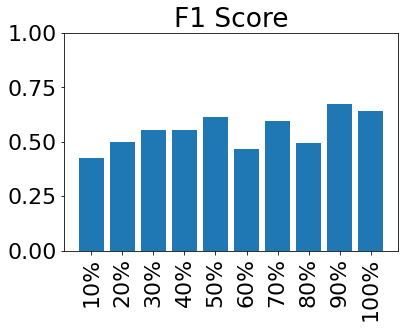

In [100]:
import matplotlib.pyplot as plt
xticks = list(metrics4.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics4[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4253114448713471, 0.49755631109222265, 0.553986622783735, 0.5528187705701242, 0.612724613455913, 0.4691165908546804, 0.5948144933825125, 0.4932010699955417, 0.6719860093999345, 0.6419753086419753]


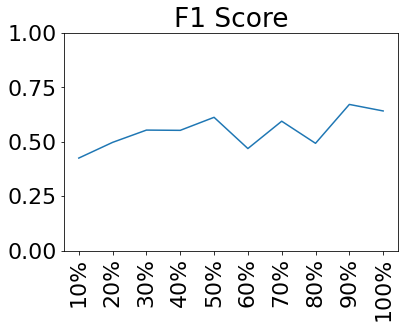

In [101]:
import matplotlib.pyplot as plt
xticks = list(metrics4.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics4[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [102]:
fig_3['Distilbert'] = y

#### Teste 2:

In [103]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()

In [104]:
metrics42 = {}
for c in spans.columns[2:]:
    metrics42[c] = evaluate(spans, 'annotation', c)
# metrics

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.594776748104465, 0.7294145644930985, 0.8088760035682426, 0.8183254344391786, 0.8364075537988581, 0.6756410256410256, 0.8302097278000892, 0.7097591888466412, 0.8611467693624305, 0.8680170575692965]


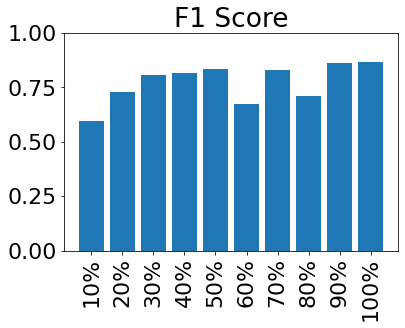

In [105]:
import matplotlib.pyplot as plt
xticks = list(metrics42.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics42[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.594776748104465, 0.7294145644930985, 0.8088760035682426, 0.8183254344391786, 0.8364075537988581, 0.6756410256410256, 0.8302097278000892, 0.7097591888466412, 0.8611467693624305, 0.8680170575692965]


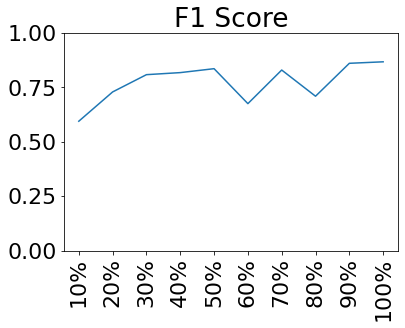

In [106]:
import matplotlib.pyplot as plt
xticks = list(metrics42.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics42[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [107]:
fig_3_1['Distilbert'] = y

## NER_news

### pegando PKL

In [108]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/nernews/dict_nernews100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

### Aplicando

#### Avaliando

In [109]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'nota_empenho',
                                'natureza_despesa',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [110]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [111]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [112]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [113]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('SAÚDE', 'partes_contratuais'), ('DF INAS', 'partes_contratuais'), ('DOS', 'partes_contratuais'), ('LTDA', 'partes_contratuais'), ('SAÚDE DF', 'partes_contratuais'), ('CREDEC

In [114]:
df = pd.DataFrame()
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['10%'] = lista_spans[1]
df['20%'] = lista_spans[2]
df['30%'] = lista_spans[3]
df['40%'] = lista_spans[4]
df['50%'] = lista_spans[5]
df['60%'] = lista_spans[6]
df['70%'] = lista_spans[7]
df['80%'] = lista_spans[8]
df['90%'] = lista_spans[9]
df['100%'] = lista_spans[10]

In [115]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                                   10%  \
0    [(SAÚDE, partes_contratuais), (DF INAS, partes...   
1    [(BALTAZAR MOURA ARQUITETURA E ENGENHARIA EIRE...   
2    [(tem por objeto a prestação de serviços de em...   
3    [(01/2021, numero_contrato), (TELECOMUNICAÇÕES...   
4    [(02/2021, numero_contrato), (Aprendizagem, pa...   
..                                                 ...   
375  [(00431-00020054/2021-17, processo_gdf), (GÁS ...   
376  [(00070-00004017/2021-18, processo_gdf), (VISU...   
377  [(SAÚDE DOS, partes_contratuais), (DF INAS, pa...   
378  [(04001-0000000016/2021-13, processo_gdf), (10...   
379  [(SEEDF, partes_contratuais), (PARA ORTOPEDIA ...   

                                                   20%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(03/2021, numero_contrato), (BALTAZAR MOURA A...   
2    [(O presente Contrato tem por objeto a prestaç...   
3    [(01/2021, numero_contrato), (TELECOMUNICAÇÕES...   
4    [(02/2021, numero_contrato), (TÉCNICO CIENTÍFI...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (OURO GÁS LTD...   
376  [(VISUAL, partes_contratuais), (E COMERCIO DE ...   
377  [(04001-0000000245/2021-20, processo_gdf), (SA...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(SEEDF, partes_contratuais), (PARA, partes_co...   

                                                   30%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (03/2021, nume...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (Companhia, parte...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (PARA...   

                                                   40%  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (03/2021, nume...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (de, partes_contr...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (040

In [116]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                                   10%  \
0    [{'label': 'partes_contratuais', 'start': 105,...   
1    [{'label': 'partes_contratuais', 'start': 239,...   
2    [{'label': 'objeto_contrato', 'start': 242, 'e...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'processo_gdf', 'start': 45, 'end':...   
376  [{'label': 'processo_gdf', 'start': 86, 'end':...   
377  [{'label': 'partes_contratuais', 'start': 107,...   
378  [{'label': 'processo_gdf', 'start': 44, 'end':...   
379  [{'label': 'partes_contratuais', 'start': 97, ...   

                                                   20%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 133, 'e...   
2    [{'label': 'objeto_contrato', 'start': 222, 'e...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'partes_contratuais', 'start': 130,...   
377  [{'label': 'processo_gdf', 'start': 45, 'end':...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'partes_contratuais', 'start': 97, ...   

                                                   30%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                                   40%  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

#### Teste 1:

In [117]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [118]:
metrics5 = {}
for c in spans.columns[2:]:
    metrics5[c] = evaluate(spans, 'annotation', c)
#metrics5

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.22276812462552428, 0.249729859526954, 0.3555533577292058, 0.4285058526509066, 0.4372020725388601, 0.4975433999344907, 0.535852392000884, 0.5919334558467937, 0.5719003302311617, 0.591388589881593]


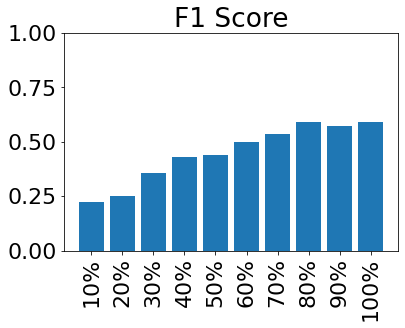

In [119]:
import matplotlib.pyplot as plt
xticks = list(metrics5.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics5[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.22276812462552428, 0.249729859526954, 0.3555533577292058, 0.4285058526509066, 0.4372020725388601, 0.4975433999344907, 0.535852392000884, 0.5919334558467937, 0.5719003302311617, 0.591388589881593]


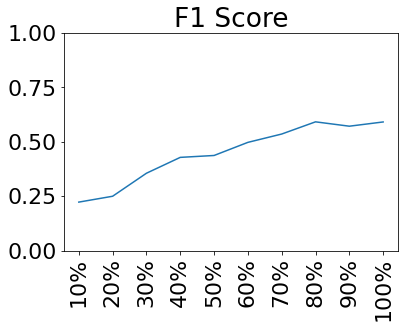

In [120]:
import matplotlib.pyplot as plt
xticks = list(metrics5.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics5[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [121]:
fig_3['NerNews'] = y

#### Teste 2:

In [122]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho']).evaluate()

In [123]:
metrics52 = {}
for c in spans.columns[2:]:
    metrics52[c] = evaluate(spans, 'annotation', c)
# metrics

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]


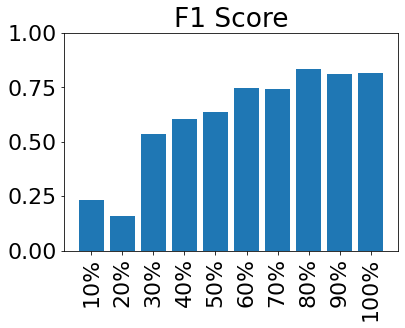

In [124]:
import matplotlib.pyplot as plt
xticks = list(metrics52.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics52[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]


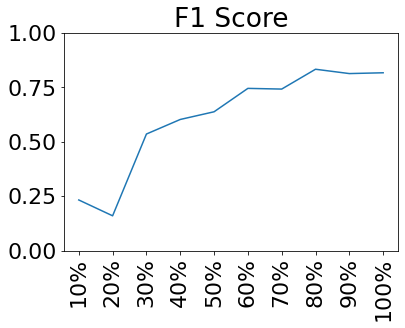

In [125]:
import matplotlib.pyplot as plt
xticks = list(metrics52.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics52[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [126]:
fig_3_1['NerNews'] = y

## POLOTANDO

In [127]:
import matplotlib.pyplot as plt
xticks = list(metrics1.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y1 = [metrics1[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics2.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y2 = [metrics2[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics3.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y3 = [metrics3[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics4.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y4 = [metrics4[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics5.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y5 = [metrics5[x][0]['partial']['f1'] for x in xticks]
print(y)
 

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 

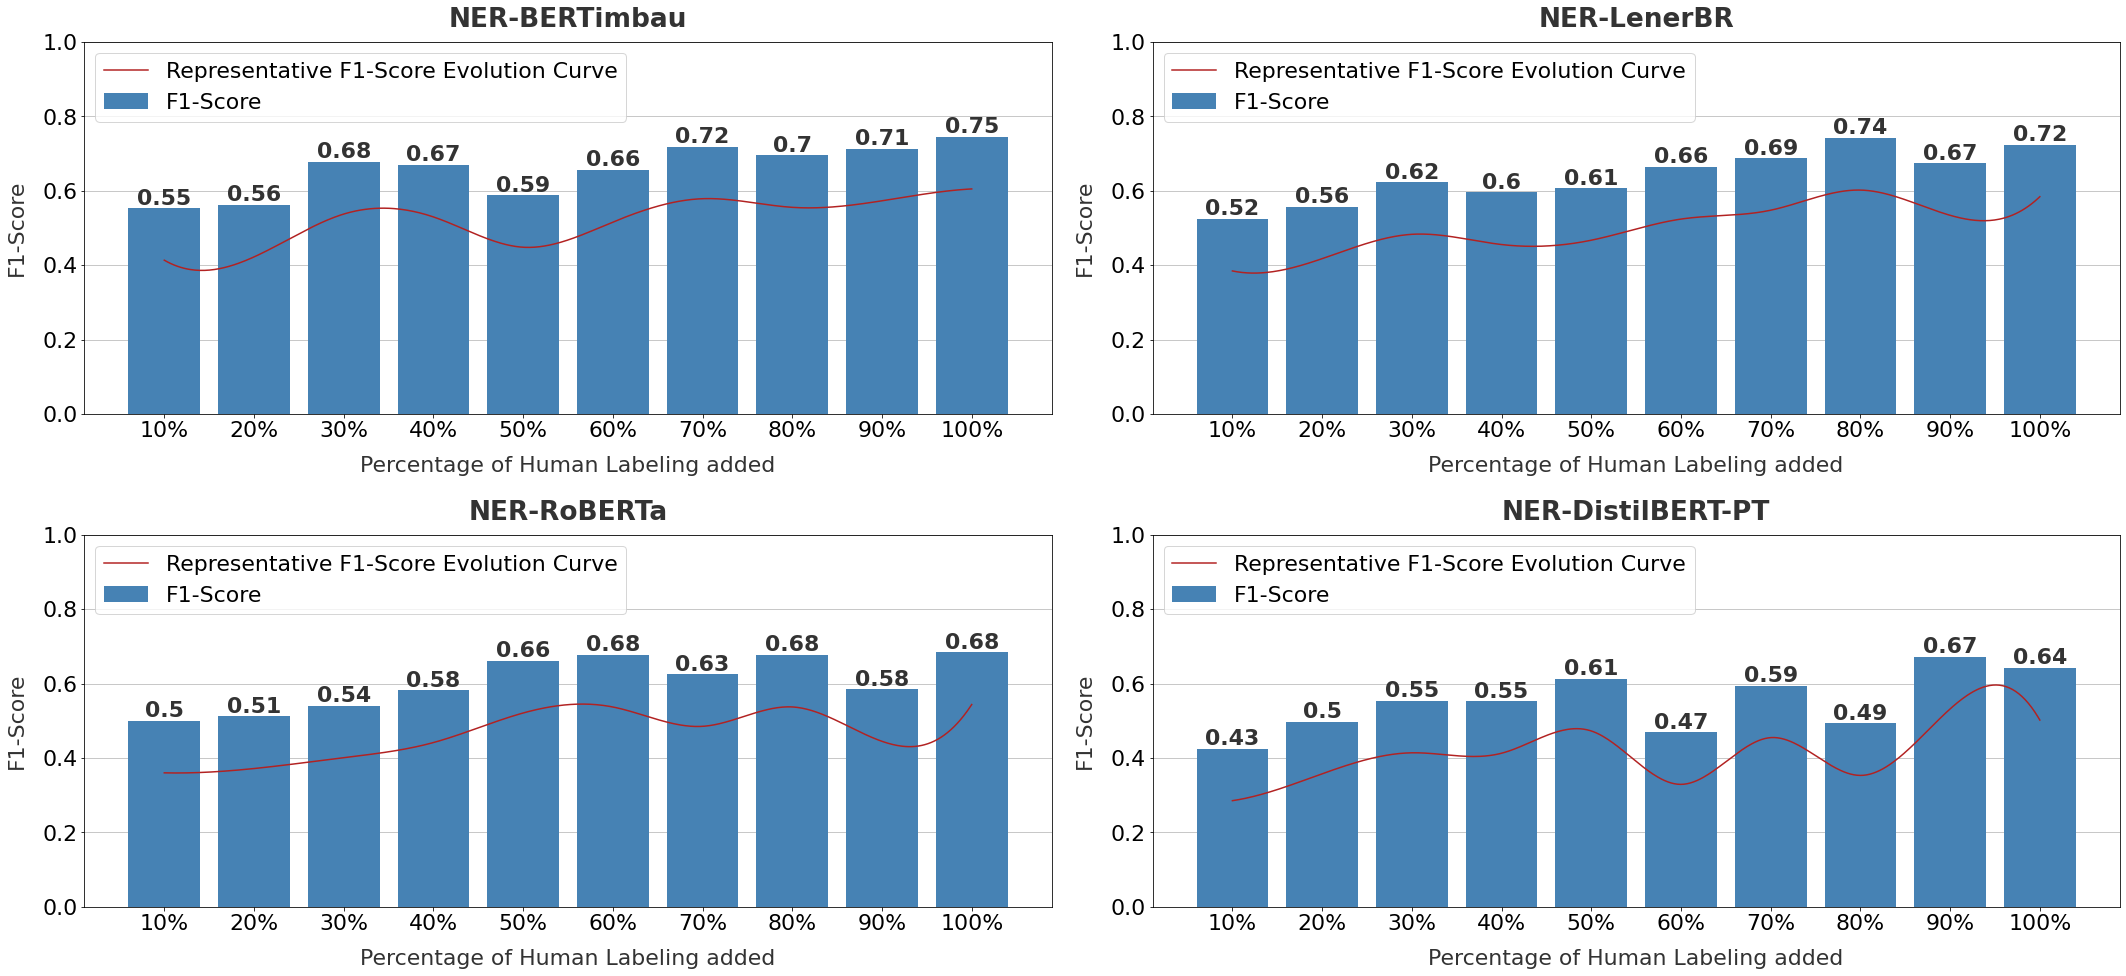

In [128]:
from scipy.interpolate import make_interp_spline

fig = plt.figure(figsize=(30, 20))

yi =  [y1,y2,y3,y4]

ax1 = plt.subplot2grid((3,4), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)

ax_vet=[ax1,ax2,ax3,ax4]

# Save the chart so we can loop through the bars below.
cont=0
for i in ax_vet:
    bars = i.bar(x, yi[cont], color='steelblue')

    #auxy = [j for j in yi[cont]]
    #i.plot(x,auxy, color = 'green')
    #i.scatter(x,auxy, color = 'green')

    T = np.array(x)

    auxy = [j-0.14 for j in yi[cont]]

    X_Y_Spline = make_interp_spline(T, auxy)
 
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(T.min(), T.max(), 500)
    Y_ = X_Y_Spline(X_)

    i.plot(X_,Y_,color = 'firebrick')
    cont+=1

    # Axis formatting.
    #i.spines['top'].set_visible(False)
    #i.spines['right'].set_visible(False)
    #i.spines['left'].set_visible(False)
    #i.spines['bottom'].set_color('#DDDDDD')
    #i.tick_params(bottom=False, left=False)
    i.set_axisbelow(True)
    i.yaxis.grid(True, color='#BBBBBB')
    # i.xaxis.grid(True, color='#EEEEEE')

    bar_color = bars[0].get_facecolor()
    for bar in bars:
      i.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.01,
          round(bar.get_height(), 2),
          horizontalalignment='center',
          color='#333333',
          weight='bold'
      )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    i.set_xticks(x)
    i.set_xticklabels(xticks, rotation='horizontal')
    i.set_xlabel('Percentage of Human Labeling added', labelpad=15, color='#333333')
    i.set_ylabel('F1-Score', labelpad=15, color='#333333')
    i.set_ylim([0.0, 1])
    #i.set_title('Chart finding best perfoming Named Entities', pad=15, color='#333333',weight='bold')

ax1.set_title('NER-BERTimbau', pad=15, color='#333333',weight='bold')
ax2.set_title('NER-LenerBR', pad=15, color='#333333',weight='bold')
ax3.set_title('NER-RoBERTa', pad=15, color='#333333',weight='bold')
ax4.set_title('NER-DistilBERT-PT', pad=15, color='#333333',weight='bold')
ax1.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='upper left')
ax2.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='upper left')
ax3.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='upper left')
ax4.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='upper left')

fig.tight_layout()
plt.savefig('chart2.pdf',pad_inches=0) 
plt.show()

## POLOTANDO 2

In [139]:
import matplotlib.pyplot as plt
xticks = list(metrics12.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y1 = [metrics12[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics22.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y2 = [metrics22[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics32.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y3 = [metrics32[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics42.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y4 = [metrics42[x][0]['partial']['f1'] for x in xticks]
print(y)
 
import matplotlib.pyplot as plt
xticks = list(metrics52.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y5 = [metrics52[x][0]['partial']['f1'] for x in xticks]
print(y)
 

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2325982081323225, 0.15977859778597786, 0.5358698809178043, 0.6028485346480417, 0.6382124698956382, 0.7458251473477407, 0.7426129426129426, 0.8338180307436643, 0.8138930967323091, 0.8175814165338192]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 

In [140]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


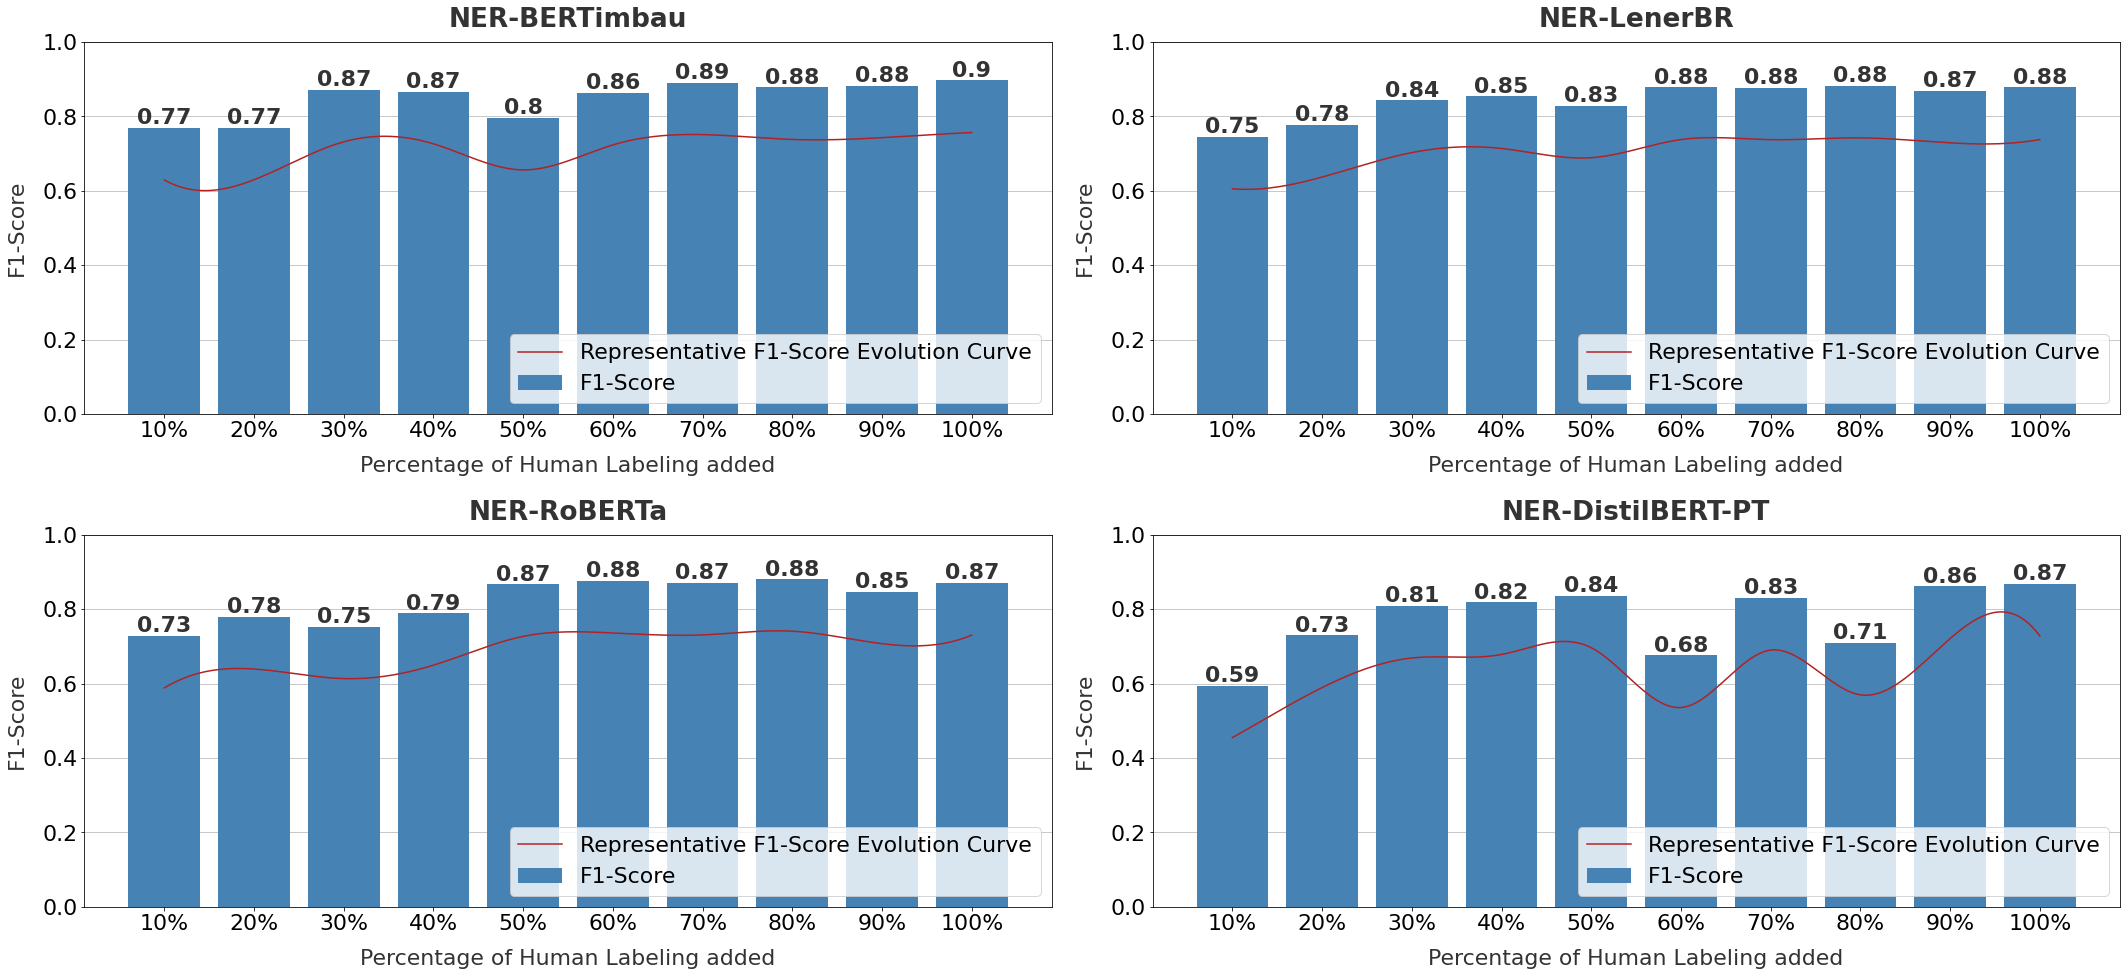

In [147]:
from scipy.interpolate import make_interp_spline

fig = plt.figure(figsize=(30, 20))

yi =  [y1,y2,y3,y4]

ax1 = plt.subplot2grid((3,4), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)

ax_vet=[ax1,ax2,ax3,ax4]

# Save the chart so we can loop through the bars below.
cont=0
for i in ax_vet:
    bars = i.bar(x, yi[cont], color='steelblue')

    #auxy = [j for j in yi[cont]]
    #i.plot(x,auxy, color = 'green')
    #i.scatter(x,auxy, color = 'green')

    T = np.array(x)

    auxy = [j-0.14 for j in yi[cont]]

    X_Y_Spline = make_interp_spline(T, auxy)
 
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(T.min(), T.max(), 500)
    Y_ = X_Y_Spline(X_)

    i.plot(X_,Y_,color = 'firebrick')
    cont+=1

    # Axis formatting.
    #i.spines['top'].set_visible(False)
    #i.spines['right'].set_visible(False)
    #i.spines['left'].set_visible(False)
    #i.spines['bottom'].set_color('#DDDDDD')
    #i.tick_params(bottom=False, left=False)
    i.set_axisbelow(True)
    i.yaxis.grid(True, color='#BBBBBB')
    # i.xaxis.grid(True, color='#EEEEEE')

    bar_color = bars[0].get_facecolor()
    for bar in bars:
      i.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.01,
          round(bar.get_height(), 2),
          horizontalalignment='center',
          color='#333333',
          weight='bold'
      )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    i.set_xticks(x)
    i.set_xticklabels(xticks, rotation='horizontal')
    i.set_xlabel('Percentage of Human Labeling added', labelpad=15, color='#333333')
    i.set_ylabel('F1-Score', labelpad=15, color='#333333')
    i.set_ylim([0.0, 1])
    #i.set_title('Chart finding best perfoming Named Entities', pad=15, color='#333333',weight='bold')

ax1.set_title('NER-BERTimbau', pad=15, color='#333333',weight='bold')
ax2.set_title('NER-LenerBR', pad=15, color='#333333',weight='bold')
ax3.set_title('NER-RoBERTa', pad=15, color='#333333',weight='bold')
ax4.set_title('NER-DistilBERT-PT', pad=15, color='#333333',weight='bold')
ax1.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='lower right')
ax2.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='lower right')
ax3.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='lower right')
ax4.legend(labels=['Representative F1-Score Evolution Curve', 'F1-Score'],loc='lower right')

fig.tight_layout()
plt.savefig('chart3.pdf',pad_inches=0) 
plt.show()

## plot para porcentagens

In [132]:
def percentage(part, whole):
  return float(part)/float(whole)


# 0.755
# 0.761
# 0.707
# 0.631
# 0.551

# NER-BERTimbau       &0.776   &0.887   &0.902 \\
# NER-LenerBR         &0.815   &0.878   &0.906 \\
# NER-RoBERTa         &0.798   &0.881   &0.899 \\ 
# NER-DistilBERT-PT   &0.664   &0.847   &0.804 \\
# NER-News            &0.000   &0.582   &0.695 \\

import matplotlib.pyplot as plt
xticks = list(metrics1.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y1 = [percentage(metrics1[x][0]['partial']['f1'],0.755) for x in xticks]
print(y1)
 
import matplotlib.pyplot as plt
xticks = list(metrics2.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y2 = [percentage(metrics2[x][0]['partial']['f1'],0.761) for x in xticks]
print(y2)
 
import matplotlib.pyplot as plt
xticks = list(metrics3.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y3 = [percentage(metrics3[x][0]['partial']['f1'],0.707) for x in xticks]
print(y3)
 
import matplotlib.pyplot as plt
xticks = list(metrics4.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y4 = [percentage(metrics4[x][0]['partial']['f1'],0.631) for x in xticks]
print(y4)
 
# import matplotlib.pyplot as plt
# xticks = list(metrics5.keys())
# print(xticks)
# x = list(range(len(xticks)))
# print(x)
# y5 = [percentage(metrics5[x][0]['partial']['f1'],0.551) for x in xticks]
# print(y5)
 

import matplotlib.pyplot as plt
xticks = list(metrics12.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y12 = [percentage(metrics12[x][0]['partial']['f1'],0.902) for x in xticks]
print(y12)
 
import matplotlib.pyplot as plt
xticks = list(metrics22.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y22 = [percentage(metrics22[x][0]['partial']['f1'],0.906) for x in xticks]
print(y22)
 
import matplotlib.pyplot as plt
xticks = list(metrics32.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y32 = [percentage(metrics32[x][0]['partial']['f1'],0.899) for x in xticks]
print(y32)
 
import matplotlib.pyplot as plt
xticks = list(metrics42.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y42 = [percentage(metrics42[x][0]['partial']['f1'],0.804) for x in xticks]
print(y42)
 
# import matplotlib.pyplot as plt
# xticks = list(metrics52.keys())
# print(xticks)
# x = list(range(len(xticks)))
# print(x)
# y52 = [percentage(metrics52[x][0]['partial']['f1'],0.695) for x in xticks]
# print(y52)

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7332602449944886, 0.7449108912380457, 0.8975243018171998, 0.887304112282615, 0.7793685454472945, 0.8689802015999493, 0.9522033156079218, 0.9214363508817266, 0.9447393866418551, 0.9870110863122461]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.6895303814991532, 0.7328501602236923, 0.8188867659537447, 0.7827749121707488, 0.7980407956784399, 0.8727044965179386, 0.9040558933247222, 0.9751757217394911, 0.8860369340641239, 0.9518116754656872]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.707384320552494, 0.7237191939787516, 0.7650688629250221, 0.8225517454832346, 0.9349603241195793, 0.9577634565982768, 0.8842167099381337, 0.9579432032384662, 0.8272101062607551, 0.9671632012992146]
['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
[0, 1, 2, 3, 4, 5,

In [133]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

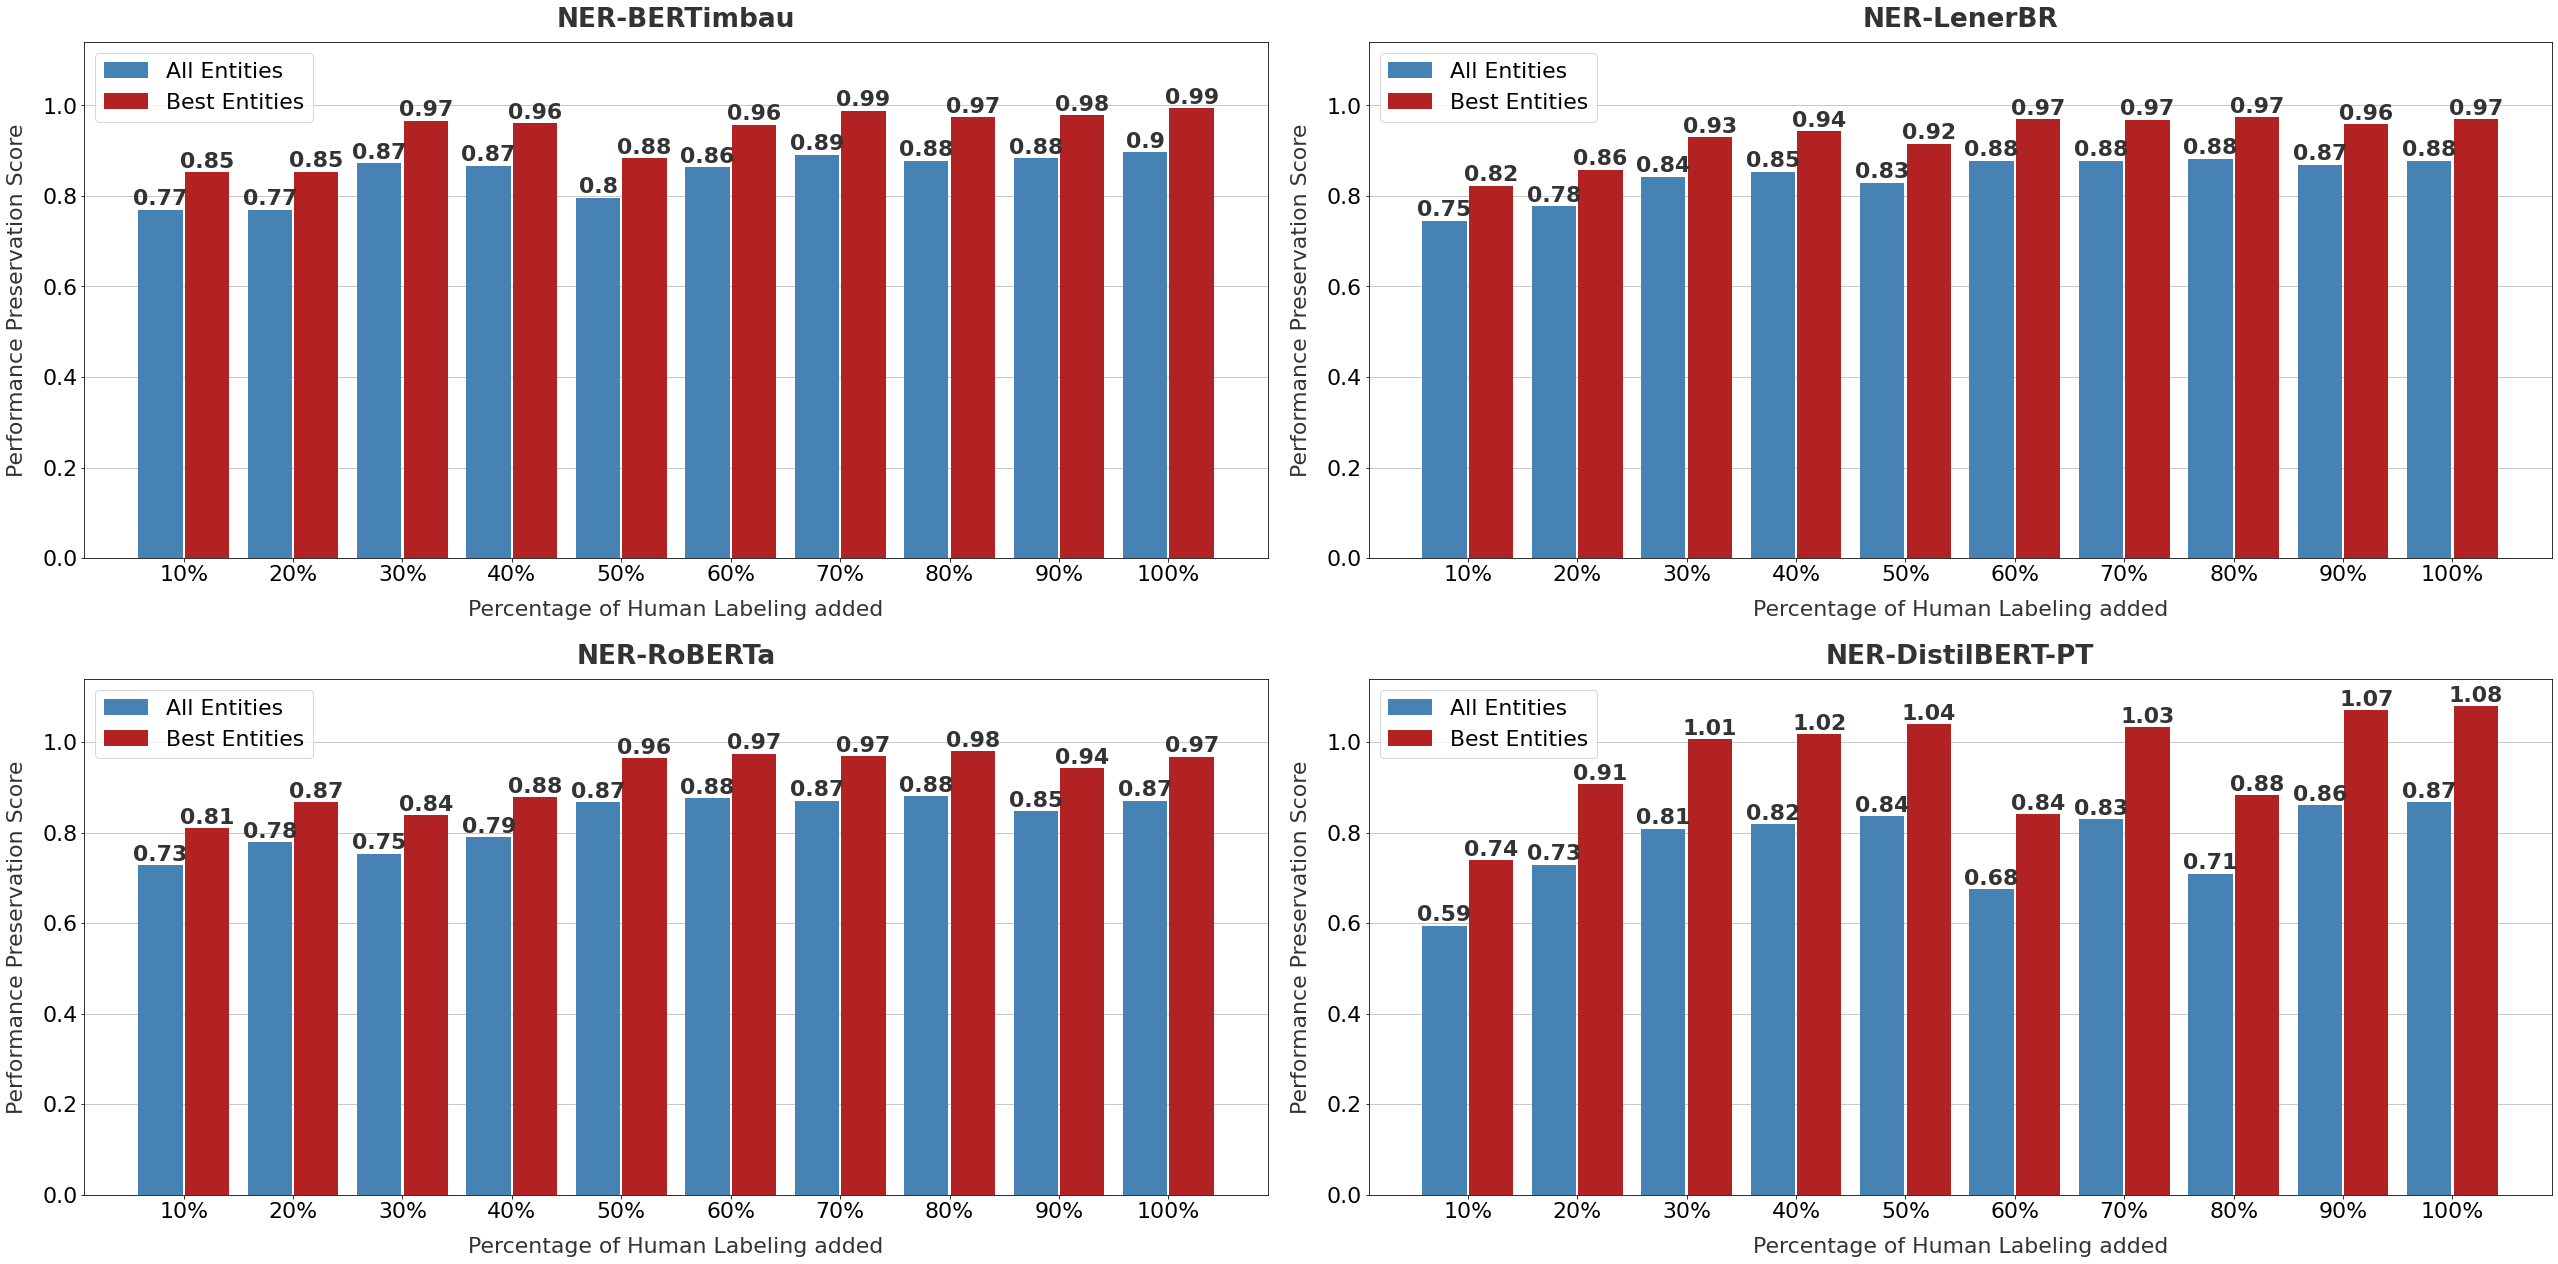

In [157]:
from scipy.interpolate import make_interp_spline

fig = plt.figure(figsize=(36, 26))

yi =  [y1,y2,y3,y4]
yi2 =  [y12,y22,y32,y42]

ax1 = plt.subplot2grid((3,4), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)

ax_vet=[ax1,ax2,ax3,ax4]
x = np.arange(10)

# Save the chart so we can loop through the bars below.
cont=0
for i in ax_vet:
    larg = 0.85
    #bars = i.bar(x-larg/4, yi[cont], width=larg/2,color='steelblue')
    #bars2 = i.bar(x+larg/4, yi2[cont], width=larg/2,color='firebrick')
    bars = i.bar(x-larg/4, yi[cont], width=(larg/2)-0.02,color='steelblue', align='center')
    bars2 = i.bar(x+larg/4, yi2[cont], width=(larg/2)-0.02,color='firebrick', align='center')
    cont+=1

    # Axis formatting.
    #i.spines['top'].set_visible(False)
    #i.spines['right'].set_visible(False)
    #i.spines['left'].set_visible(False)
    #i.spines['bottom'].set_color('#DDDDDD')
    #i.tick_params(bottom=False, left=False)
    i.set_axisbelow(True)
    i.yaxis.grid(True, color='#BBBBBB')
    # i.xaxis.grid(True, color='#EEEEEE')

    bar_color = bars[0].get_facecolor()
    for bar in bars:
      i.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.01,
          round(bar.get_height(), 2),
          horizontalalignment='center',
          color='#333333',
          weight='bold'
      )

    for bar in bars2:
        i.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.01,
          round(bar.get_height(), 2),
          horizontalalignment='center',
          color='#333333',
          weight='bold'
      )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    i.set_xticks(x)
    i.set_xticklabels(xticks, rotation='horizontal')
    i.set_xlabel('Percentage of Human Labeling added', labelpad=15, color='#333333')
    i.set_ylabel('Performance Preservation Score', labelpad=15, color='#333333')
    i.set_ylim([0.0, 1.14])
    #i.set_title('Chart finding best perfoming Named Entities', pad=15, color='#333333',weight='bold')

ax1.set_title('NER-BERTimbau', pad=15, color='#333333',weight='bold')
ax2.set_title('NER-LenerBR', pad=15, color='#333333',weight='bold')
ax3.set_title('NER-RoBERTa', pad=15, color='#333333',weight='bold')
ax4.set_title('NER-DistilBERT-PT', pad=15, color='#333333',weight='bold')
ax1.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax2.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax3.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax4.legend(labels=['All Entities', 'Best Entities'],loc='upper left')

fig.tight_layout()
plt.savefig('chart4.pdf',pad_inches=0) 
plt.show()

### TESTES OUTROS

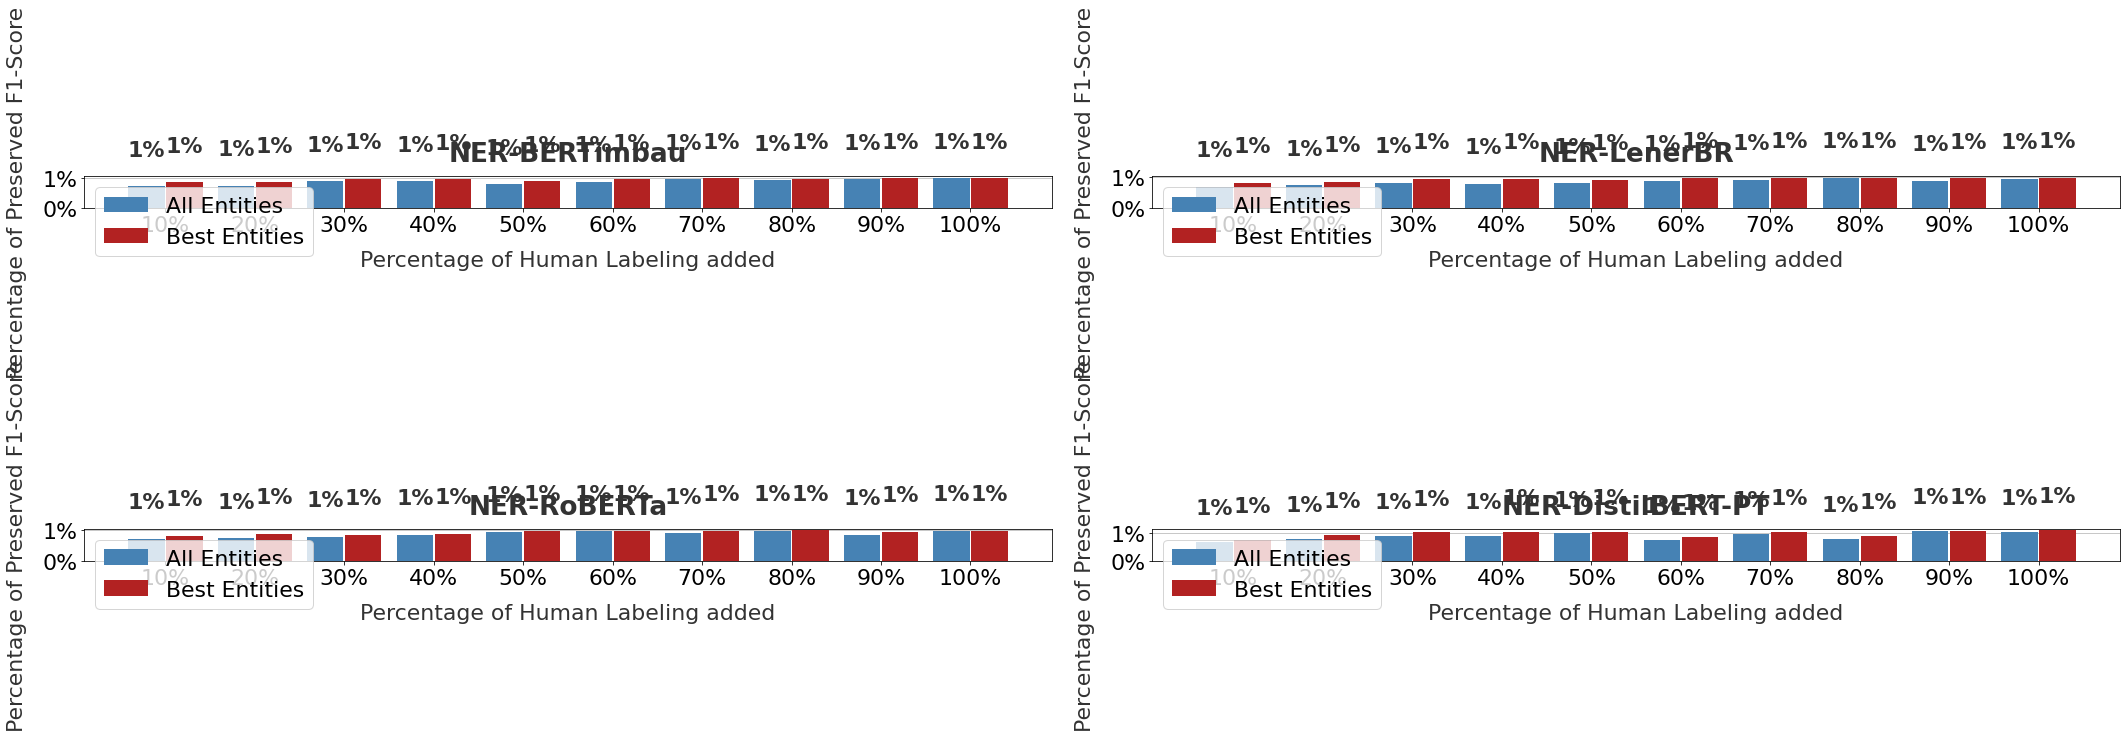

In [135]:
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(30, 14))

yi =  [y1,y2,y3,y4]
yi2 =  [y12,y22,y32,y42]

ax1 = plt.subplot2grid((3,4), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)

ax_vet=[ax1,ax2,ax3,ax4]
x = np.arange(10)

# Save the chart so we can loop through the bars below.
cont=0
for i in ax_vet:
    larg = 0.85
    #bars = i.bar(x-larg/4, yi[cont], width=larg/2,color='steelblue')
    #bars2 = i.bar(x+larg/4, yi2[cont], width=larg/2,color='firebrick')
    bars = i.bar(x-larg/4, yi[cont], width=(larg/2)-0.02,color='steelblue', align='center')
    bars2 = i.bar(x+larg/4, yi2[cont], width=(larg/2)-0.02,color='firebrick', align='center')

    # auxy = [j+0.08 for j in yi[cont]]
    # i.plot(x,auxy, color = 'green')
    # i.scatter(x,auxy, color = 'green')

    cont+=1

    # Axis formatting.
    #i.spines['top'].set_visible(False)
    #i.spines['right'].set_visible(False)
    #i.spines['left'].set_visible(False)
    #i.spines['bottom'].set_color('#DDDDDD')
    #i.tick_params(bottom=False, left=False)
    i.set_axisbelow(True)
    i.yaxis.grid(True, color='#BBBBBB')
    # i.xaxis.grid(True, color='#EEEEEE')

    bar_color = bars[0].get_facecolor()
    for bar in bars:
        i.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            str('%.0f' % round(bar.get_height(), 2))+'%',
            horizontalalignment='center',
            color='#333333',
            weight='bold'
        )
    for bar in bars2:
        i.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            str('%.0f' % round(bar.get_height(), 2))+'%',
            horizontalalignment='center',
            color='#333333',
            weight='bold'
        )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    i.set_xticks(x)
    i.set_xticklabels(xticks, rotation='horizontal')
    i.set_xlabel('Percentage of Human Labeling added', labelpad=15, color='#333333')
    i.set_ylabel('Percentage of Preserved F1-Score', labelpad=15, color='#333333')
    #i.set_ylim([0, 130])
    #i.set_title('Chart finding best perfoming Named Entities', pad=15, color='#333333',weight='bold')

ax1.set_title('NER-BERTimbau', pad=15, color='#333333',weight='bold')
ax1.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
ax2.set_title('NER-LenerBR', pad=15, color='#333333',weight='bold')
ax2.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
ax3.set_title('NER-RoBERTa', pad=15, color='#333333',weight='bold')
ax3.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
ax4.set_title('NER-DistilBERT-PT', pad=15, color='#333333',weight='bold')
ax4.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))


fig.tight_layout()

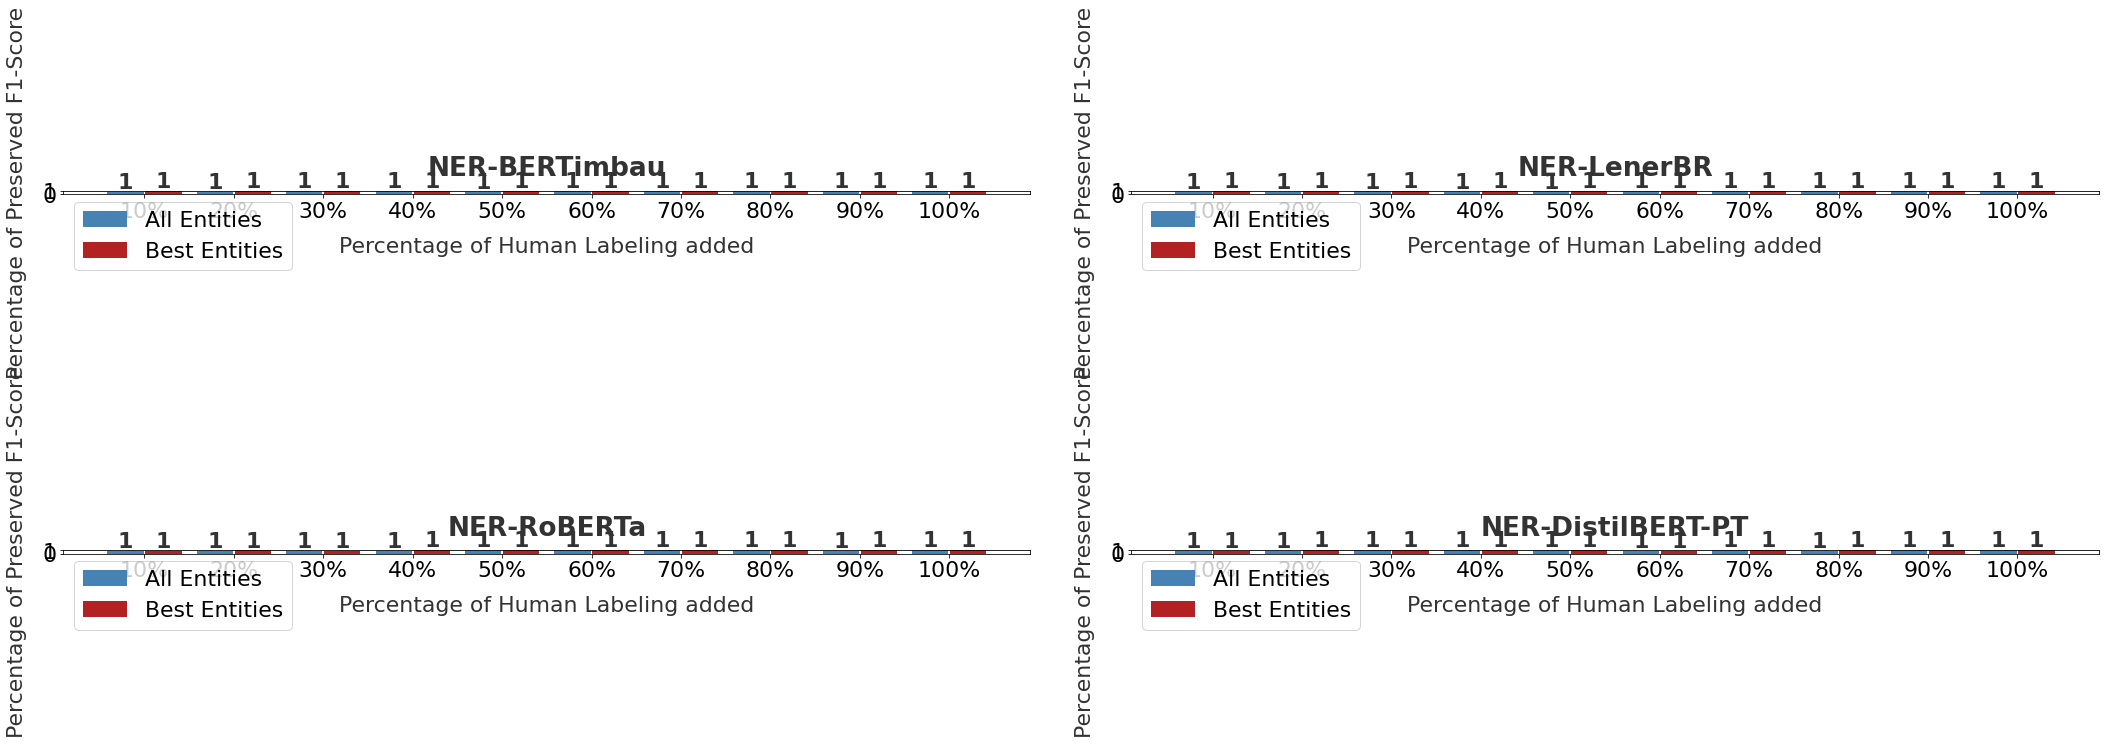

In [136]:
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(30, 14))

yi =  [y1,y2,y3,y4]
yi2 =  [y12,y22,y32,y42]

ax1 = plt.subplot2grid((3,4), (0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)

ax_vet=[ax1,ax2,ax3,ax4]
x = np.arange(10)

# Save the chart so we can loop through the bars below.
cont=0
for i in ax_vet:
    larg = 0.85
    #bars = i.bar(x-larg/4, yi[cont], width=larg/2,color='steelblue')
    #bars2 = i.bar(x+larg/4, yi2[cont], width=larg/2,color='firebrick')
    bars = i.bar(x-larg/4, yi[cont], width=(larg/2)-0.02,color='steelblue', align='center')
    bars2 = i.bar(x+larg/4, yi2[cont], width=(larg/2)-0.02,color='firebrick', align='center')

    # auxy = [j+0.08 for j in yi[cont]]
    # i.plot(x,auxy, color = 'green')
    # i.scatter(x,auxy, color = 'green')

    cont+=1

    # Axis formatting.
    #i.spines['top'].set_visible(False)
    #i.spines['right'].set_visible(False)
    #i.spines['left'].set_visible(False)
    #i.spines['bottom'].set_color('#DDDDDD')
    #i.tick_params(bottom=False, left=False)
    i.set_axisbelow(True)
    i.yaxis.grid(True, color='#BBBBBB')
    # i.xaxis.grid(True, color='#EEEEEE')

    bar_color = bars[0].get_facecolor()
    for bar in bars:
        i.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            str('%.0f' % round(bar.get_height(), 2)),
            horizontalalignment='center',
            color='#333333',
            weight='bold'
        )
    for bar in bars2:
        i.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 1,
            str('%.0f' % round(bar.get_height(), 2)),
            horizontalalignment='center',
            color='#333333',
            weight='bold'
        )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    i.set_xticks(x)
    i.set_xticklabels(xticks, rotation='horizontal')
    i.set_xlabel('Percentage of Human Labeling added', labelpad=15, color='#333333')
    i.set_ylabel('Percentage of Preserved F1-Score', labelpad=15, color='#333333')
    i.set_ylim([0.0, 1])
    #i.set_title('Chart finding best perfoming Named Entities', pad=15, color='#333333',weight='bold')

ax1.set_title('NER-BERTimbau', pad=15, color='#333333',weight='bold')
ax1.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax2.set_title('NER-LenerBR', pad=15, color='#333333',weight='bold')
ax2.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax3.set_title('NER-RoBERTa', pad=15, color='#333333',weight='bold')
ax3.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
ax4.set_title('NER-DistilBERT-PT', pad=15, color='#333333',weight='bold')
ax4.legend(labels=['All Entities', 'Best Entities'],loc='upper left')
#ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
# ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
# ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))
# ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))


fig.tight_layout()

# GPT + WeakSup 

## SALVANDO PICKLE

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_ner_news.pkl", "rb") as f:
    dict_ner_news = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_bertlenerbr.pkl", "rb") as f:
    dict_bertlenerbr = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_distilbert.pkl", "rb") as f:
    dict_distilbert = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_portuguese.pkl", "rb") as f:
    dict_portuguese = pkl.load(f)

with open("/content/drive/MyDrive/Conll_IT/WeakPlusGPT/dict_roberta.pkl", "rb") as f:
    dict_roberta = pkl.load(f)
 

## Avaliando outputs dos modelos com dados de teste:

### Avaliando

In [ ]:
entidadesExtratoContrato = [
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho',
                            ]

bestEntidadesExtratoContrato = [
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'natureza_despesa',
                                'nota_empenho',
                                ]

def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict_portuguese))
lista_spans.append(get_lista_from_dit(dict_bertlenerbr))
lista_spans.append(get_lista_from_dit(dict_roberta))
lista_spans.append(get_lista_from_dit(dict_distilbert))
lista_spans.append(get_lista_from_dit(dict_ner_news))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('INSTITUTO DE ASSIST', 'partes_contratuais'), ('BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'par

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['bertinbau'] = lista_spans[1]
df['bertlenerbr'] = lista_spans[2]
df['roberta'] = lista_spans[3]
df['distilbert'] = lista_spans[4]
df['ner_news'] = lista_spans[5]

In [ ]:
df

texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(DF/SECEC/FAC, partes_contratuais), (WAYNER T...   
3    [(339039, natureza_despesa), (01/2021, numero_...   
4    [(Companhia de Planejamento do Distrito Federa...   
..                                                 ...   
375  [(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...   
376  [(449052, natureza_despesa), (SEAGRI/DF, parte...   
377  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
378  [(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                             bertinbau  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (Pa...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                           bertlenerbr  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (45384/2021, n...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(02/2021, numero_contrato), (- SENAI/DF, part...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(26/2022, numero_contrato), (00080-00246444/2...   

                                               roberta  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (contratação d...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (00302-00001101/2...   
4    [(00121.00000.0137/2021-58, processo_gdf), (DE...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (00431-000200...   
376  [(45/2021, numero_contrato), (00070-00004017/2...   
377  [(43.980/2021, numero_contrato), (04001-000000...   
378  [(42705/2021, numero_contrato), (04001-0000000...   
379  [(00080-00246444/2021-34, processo_gdf), (SEED...   

                                            distilbert  \
0    [(43338/2021, numero_contrato), (04001-0000000...   
1    [(45384/2021, numero_contrato), (00367-0000040...   
2    [(204/2021, numero_contrato), (00150-00007305/...   
3    [(01/2021, numero_contrato), (ADMINISTRAÇÃO RE...   
4    [(00121.00000.0137/2021-58, processo_gdf), (O,...   
..                                                 ...   
375  [(045005/2021, numero_contrato), (140/2021, nu...   
376  [(45/2021, numero_contrato), (SEAGRI/DF e VISU...   
377  [(43.980/2021, numero_contrato), (040

In [ ]:
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau
bertlenerbr
roberta
distilbert
ner_news


texto  \
0    EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...   
1    EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...   
2    EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...   
3    EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...   
4    EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...   
..                                                 ...   
375  EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...   
376  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...   
377  EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...   
378  EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...   
379  EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS Nº ...   

                                            annotation  \
0    [{'label': 'partes_contratuais', 'start': 82, ...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'partes_contratuais', 'start': 78, ...   
3    [{'label': 'natureza_despesa', 'start': 910, '...   
4    [{'label': 'partes_contratuais', 'start': 98, ...   
..                                                 ...   
375  [{'label': 'partes_contratuais', 'start': 81, ...   
376  [{'label': 'natureza_despesa', 'start': 1394, ...   
377  [{'label': 'partes_contratuais', 'start': 84, ...   
378  [{'label': 'partes_contratuais', 'start': 83, ...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                             bertinbau  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                           bertlenerbr  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'numero_contrato', 'start': 71, 'en...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'numero_contrato', 'start': 46, 'en...   

                                               roberta  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start': 23, 'en...   
378  [{'label': 'numero_contrato', 'start': 23, 'en...   
379  [{'label': 'processo_gdf', 'start': 64, 'end':...   

                                            distilbert  \
0    [{'label': 'numero_contrato', 'start': 23, 'en...   
1    [{'label': 'numero_contrato', 'start': 23, 'en...   
2    [{'label': 'numero_contrato', 'start': 23, 'en...   
3    [{'label': 'numero_contrato', 'start': 47, 'en...   
4    [{'label': 'processo_gdf', 'start': 223, 'end'...   
..                                                 ...   
375  [{'label': 'numero_contrato', 'start': 23, 'en...   
376  [{'label': 'numero_contrato', 'start': 68, 'en...   
377  [{'label': 'numero_contrato', 'start'

### Teste 1

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                            'numero_contrato',
                            'processo_gdf',
                            'partes_contratuais',
                            'objeto_contrato',
                            'valor_contrato',
                            'data_assinatura_contrato',
                            'vigencia_contrato',
                            'unidade_orcamentaria',
                            'programa_trabalho',
                            'natureza_despesa',
                            'nota_empenho']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
#metrics

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.6869928124275446, 0.7091848450057405, 0.5586450960566228, 0.6326219512195123, 0.6378757276939528]


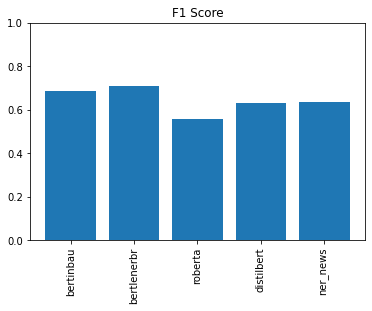

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_3['All_Entities'] = y

### Teste 2:

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=[
                                'numero_contrato',
                                'processo_gdf',
                                'valor_contrato',
                                'unidade_orcamentaria',
                                'programa_trabalho',
                                'nota_empenho',
                                'natureza_despesa',]).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
#metrics

['bertinbau', 'bertlenerbr', 'roberta', 'distilbert', 'ner_news']
[0, 1, 2, 3, 4]
[0.884549356223176, 0.8880703908328218, 0.7730358874878759, 0.8314880425155006, 0.8134311763397821]


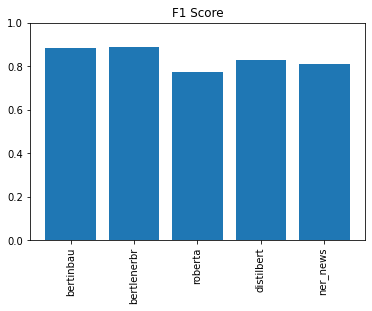

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

# bars = [round(i, 2) for i in y]
# ax.bar_label(bars)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
table_3['Best_Entities'] = y

# MOSTRANDO .CSVs:

In [ ]:
table_1 

GPT-3   WeakSup    Humano
0  0.543648  0.703717  0.755617
1  0.554780  0.676967  0.761157
2  0.542734  0.674856  0.707105
3  0.473220  0.664633  0.631985
4  0.278618  0.413657  0.551531

In [ ]:
table_2 

GPT-3   WeakSup    Humano
0  0.776207  0.887001  0.902990
1  0.815140  0.878696  0.906071
2  0.798961  0.881802  0.899285
3  0.664423  0.847623  0.804006
4  0.000000  0.582081  0.695812

In [ ]:
table_3

All_Entities  Best_Entities
0      0.686993       0.884549
1      0.709185       0.888070
2      0.558645       0.773036
3      0.632622       0.831488
4      0.637876       0.813431

In [ ]:
fig_2 

Entidades  Bertimbau  Bertlener   Roberta  Distlbert  \
0            numero_contrato   0.963051   0.958726  0.916856   0.854054   
1               processo_gdf   0.958886   0.968085  0.962716   0.847858   
2         partes_contratuais   0.672243   0.650999  0.469176   0.531063   
3            objeto_contrato   0.487548   0.565041  0.456414   0.346568   
4             valor_contrato   0.876633   0.885027  0.889037   0.719937   
5   data_assinatura_contrato   0.541339   0.561368  0.626316   0.489796   
6          vigencia_contrato   0.516046   0.466328  0.502463   0.478580   
7       unidade_orcamentaria   0.792419   0.791150  0.794326   0.785321   
8          programa_trabalho   0.912664   0.912732  0.910791   0.730706   
9           natureza_despesa   0.899648   0.909250  0.906690   0.862709   
10              nota_empenho   0.885174   0.887931  0.903736   0.853695   

     NerNews  
0   0.878581  
1   0.810345  
2   0.599327  
3   0.278467  
4   0.094086  
5   0.307692  
6   0.407143  
7   0.674948  
8   0.721170  
9   0.676923  
10  0.748777

In [ ]:
fig_3 

Bertimbau  Bertlener   Roberta  Distilbert   NerNews
0   0.553611   0.524733  0.500121    0.425311  0.222768
1   0.562408   0.557699  0.511669    0.497556  0.249730
2   0.677631   0.623173  0.540904    0.553987  0.355553
3   0.669915   0.595692  0.581544    0.552819  0.428506
4   0.588423   0.607309  0.661017    0.612725  0.437202
5   0.656080   0.664128  0.677139    0.469117  0.497543
6   0.718914   0.687987  0.625141    0.594814  0.535852
7   0.695684   0.742109  0.677266    0.493201  0.591933
8   0.713278   0.674274  0.584838    0.671986  0.571900
9   0.745193   0.724329  0.683784    0.641975  0.591389

In [ ]:
fig_3_1 

Bertimbau  Bertlener   Roberta  Distilbert   NerNews
0   0.769380   0.745645  0.728357    0.594777  0.232598
1   0.769880   0.777157  0.779221    0.729415  0.159779
2   0.871823   0.842923  0.753506    0.808876  0.535870
3   0.866424   0.853955  0.789560    0.818325  0.602849
4   0.796327   0.829150  0.866909    0.836408  0.638212
5   0.863547   0.877876  0.876110    0.675641  0.745825
6   0.891231   0.877676  0.870954    0.830210  0.742613
7   0.878185   0.882461  0.880901    0.709759  0.833818
8   0.883037   0.869005  0.847356    0.861147  0.813893
9   0.896735   0.877891  0.870297    0.868017  0.817581

## salvando .CSVs

In [ ]:
table_1.to_csv('/content/drive/MyDrive/SavesFinal/CSV/table1.csv')
table_2.to_csv('/content/drive/MyDrive/SavesFinal/CSV/table2.csv')
table_3.to_csv('/content/drive/MyDrive/SavesFinal/CSV/table3.csv')
fig_2.to_csv('/content/drive/MyDrive/SavesFinal/CSV/fig2.csv')
fig_3.to_csv('/content/drive/MyDrive/SavesFinal/CSV/fig3.csv')
fig_3_1.to_csv('/content/drive/MyDrive/SavesFinal/CSV/fig4.csv')